# BLLARSE — W&B Sweep Analysis

This notebook helps you:
- Pull runs for a given `ENTITY/PROJECT` and `GROUP`
- Build a tidy DataFrame of run **configs + summaries**
- Count **unique configurations** (dedupe retries)
- Slice success/failure counts per condition grid
- Plot simple metrics distributions

> **Auth:** run `wandb login` in a terminal or set `WANDB_API_KEY` in your environment before executing.


In [ ]:
# ==== Config (edit me) ========================================================
ENTITY  = "MY_ENTITY_NAME"                 # W&B entity/org
PROJECT = "bllarse_experiments"       # W&B project
GROUP   = "sweep2_batchsize_numiters" # W&B group filter

# Optional: further filters (e.g., state, created range)
ONLY_STATE = "finished"   # set to None for all states, or "finished"/"crashed"/...

# Where to save CSVs/figures
OUTDIR = "wandb_analysis_bllarse"

print(f"Filters -> ENTITY/PROJECT: {ENTITY}/{PROJECT} | GROUP: {GROUP} | STATE: {ONLY_STATE}")


Filters -> ENTITY/PROJECT: verses_ai/bllarse_experiments | GROUP: sweep2_batchsize_numiters | STATE: finished


In [2]:
# ==== Imports =================================================================
import os, math, json
from typing import Any, Dict, List, Tuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wandb

# Make output dir
os.makedirs(OUTDIR, exist_ok=True)

# Matplotlib defaults (simple)
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.grid": True,
})


In [3]:
# ==== Helper functions ========================================================
Run = wandb.apis.public.Run

def _get(d: Dict[str, Any], key: str, default=None):
    try:
        return d.get(key, default)
    except Exception:
        return default

# Config keys we care about (as logged in wandb.init config).
# epochs was NOT logged; we'll backfill it from the summary.
CFG_KEYS = [
    "dataset",
    "seed",
    "batch_size",
    "num_vb_iters",
    "pretrained",
    # "epochs"  # not logged; do NOT rely on config for this
]

# Keys that define a *unique configuration* for this sweep
# (include epochs so ON/OFF are distinguishable; we’ll fill epochs below)
UNIQUE_KEYS = [
    "dataset",
    "pretrained",
    "batch_size",
    "num_vb_iters",
    "seed",
    "epochs",
]

SUMMARY_KEYS = [
    "acc", "nll", "ece", "loss", "epoch", "_runtime", "_step", "_exit_code"
]

def fetch_runs(entity: str, project: str, group: str, only_state: str | None = "finished") -> List[Run]:
    api = wandb.Api()
    path = f"{entity}/{project}"
    filters = {"group": group}
    if only_state is not None:
        filters["state"] = only_state
    print(f"Querying W&B: {path} with filters={filters}")
    runs = list(api.runs(path=path, filters=filters, order="-created_at"))
    print(f"Found {len(runs)} runs.")
    return runs

def as_config_row(run: Run) -> Dict[str, Any]:
    cfg = dict(run.config or {})
    row = {k: _get(cfg, k) for k in CFG_KEYS}

    # Base identifiers
    row["group_id"]  = getattr(run, "group", None)
    row["run_id"]    = run.id
    row["name"]      = run.name
    row["state"]     = run.state

    # Summaries (incl. 'epoch' which we need to backfill epochs)
    for k in SUMMARY_KEYS:
        row[k] = run.summary.get(k, np.nan)

    # Backfill epochs:
    # prefer config if present (future-proof), else use summary['epoch'] (last logged epoch)
    epochs_cfg = _get(cfg, "epochs")
    epochs_sum = row.get("epoch")
    row["epochs"] = epochs_cfg if pd.notna(epochs_cfg) else epochs_sum

    return row

def tidy_df(runs: List[Run]) -> pd.DataFrame:
    rows = [as_config_row(r) for r in runs]
    df = pd.DataFrame(rows)

    # Coerce numeric-ish
    for k in ["seed","batch_size","num_vb_iters","epochs"]:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce")

    return df

def count_unique_configs(df: pd.DataFrame, keys: List[str]) -> Tuple[int, pd.DataFrame]:
    if df.empty:
        return 0, df
    # unique rows by keys; keep first occurrence per condition
    unique = df.drop_duplicates(subset=keys, keep="first").copy()
    return unique.shape[0], unique

def dedupe_and_mark(df: pd.DataFrame, keys: List[str]) -> pd.DataFrame:
    if df.empty:
        df["is_unique"] = []
        return df
    # mark duplicates (beyond the first occurrence)
    dup_mask = df.duplicated(subset=keys, keep="first")
    out = df.copy()
    out["is_unique"] = ~dup_mask
    return out

def pivot_counts(df: pd.DataFrame, keys: List[str]) -> pd.DataFrame:
    if df.empty:
        return df
    grp = df.groupby(keys, dropna=False).agg(n_runs=("run_id","count")).reset_index()
    return grp.sort_values("n_runs", ascending=False)


### Pull data

- We don’t rely on config for epochs; we backfill from summary["epoch"].
- UNIQUE_KEYS includes epochs, so ON vs OFF will be distinct.
- nodataaug is inferred deterministically using epochs (primary) and num_vb_iters (secondary guard).

In [4]:
# ==== Pull data ===============================================================
runs = fetch_runs(ENTITY, PROJECT, GROUP, ONLY_STATE)
DF = tidy_df(runs)

# Reconstruct data augmentation flag from sweep design
# OFF => epochs == 5 or vbi in {48,64,96,128}
# ON  => epochs == 20
VB_OFF_ONLY = {48, 64, 96, 128}

def infer_nodataaug(row):
    e = row.get("epochs")
    vbi = row.get("num_vb_iters")
    if pd.notna(e):
        try:
            e_int = int(e)
            if e_int == 5:
                return True   # OFF
            if e_int == 20:
                return False  # ON
        except Exception:
            pass
    if pd.notna(vbi):
        try:
            if int(vbi) in VB_OFF_ONLY:
                return True   # OFF
        except Exception:
            pass
    return np.nan  # unknown

DF["nodataaug"] = DF.apply(infer_nodataaug, axis=1)

# Sanity checks
print("nodataaug value counts (after inference):")
print(DF["nodataaug"].value_counts(dropna=False))
print("Epochs (from config-or-summary) stats:")
print(DF["epochs"].describe())

print("Rows:", len(DF))
display(DF.head())

# Save raw table
DF.to_csv(Path(OUTDIR) / "runs_raw.csv", index=False)
print("Saved:", Path(OUTDIR) / "runs_raw.csv")


Querying W&B: verses_ai/bllarse_experiments with filters={'group': 'sweep2_batchsize_numiters', 'state': 'finished'}
Found 2409 runs.
nodataaug value counts (after inference):
nodataaug
True     1488
False     921
Name: count, dtype: int64
Epochs (from config-or-summary) stats:
count    2409.000000
mean       10.734745
std         7.290812
min         5.000000
25%         5.000000
50%         5.000000
75%        20.000000
max        20.000000
Name: epochs, dtype: float64
Rows: 2409


,dataset,seed,batch_size,num_vb_iters,pretrained,group_id,run_id,name,state,acc,nll,ece,loss,epoch,_runtime,_step,_exit_code,epochs,nodataaug
0,cifar100,1,30000,32,in21k_cifar,sweep2_batchsize_numiters,5h8cb7jn,robust-shape-2908,finished,0.7787,1.020433,0.043152,1.284048,20,220,39,NaN,20,False
1,cifar100,0,30000,32,in21k_cifar,sweep2_batchsize_numiters,6wssj7lt,exalted-gorge-2908,finished,0.7811,1.021013,0.043938,1.264807,20,213,39,NaN,20,False
2,cifar100,4,30000,32,in21k_cifar,sweep2_batchsize_numiters,ponq18xp,golden-moon-2907,finished,0.7827,1.028630,0.046502,1.279638,20,223,39,NaN,20,False
3,cifar100,2,30000,16,in21k_cifar,sweep2_batchsize_numiters,2hxba999,decent-waterfall-2902,finished,0.7803,1.170480,0.133415,1.529113,20,232,39,NaN,20,False
4,cifar100,2,30000,32,in21k_cifar,sweep2_batchsize_numiters,qu6dfgfe,dutiful-leaf-2902,finished,0.7790,1.021945,0.044983,1.308254,20,226,39,NaN,20,False


Saved: wandb_analysis_bllarse/runs_raw.csv


In [5]:
# ==== Unique configuration accounting ========================================
n_unique, UNIQUE = count_unique_configs(DF, UNIQUE_KEYS)
print(f"Unique configs by {UNIQUE_KEYS}: {n_unique}")

UNIQUE.to_csv(Path(OUTDIR) / "runs_unique_by_config.csv", index=False)
print("Saved:", Path(OUTDIR) / "runs_unique_by_config.csv")

DEDUPED = dedupe_and_mark(DF, UNIQUE_KEYS)
counts = pivot_counts(DEDUPED, UNIQUE_KEYS)
display(counts.head(20))

# Simple diagnostics
print("\nCounts by dataset (all runs):")
display(DF["dataset"].value_counts(dropna=False))

print("\nCounts by dataset (unique configs):")
display(UNIQUE["dataset"].value_counts(dropna=False))

print("\nStates:")
display(DF["state"].value_counts(dropna=False))


Unique configs by ['dataset', 'pretrained', 'batch_size', 'num_vb_iters', 'seed', 'epochs']: 2384
Saved: wandb_analysis_bllarse/runs_unique_by_config.csv


,dataset,pretrained,batch_size,num_vb_iters,seed,epochs,n_runs
20,cifar10,in21k,512,2,4,5,2
24,cifar10,in21k,512,4,0,5,2
26,cifar10,in21k,512,4,1,5,2
28,cifar10,in21k,512,4,2,5,2
30,cifar10,in21k,512,4,3,5,2
32,cifar10,in21k,512,4,4,5,2
36,cifar10,in21k,512,8,0,5,2
18,cifar10,in21k,512,2,3,5,2
40,cifar10,in21k,512,8,2,5,2
42,cifar10,in21k,512,8,3,5,2



Counts by dataset (all runs):


dataset
cifar10     1368
cifar100    1041
Name: count, dtype: int64


Counts by dataset (unique configs):


dataset
cifar10     1344
cifar100    1040
Name: count, dtype: int64


States:


state
finished    2409
Name: count, dtype: int64

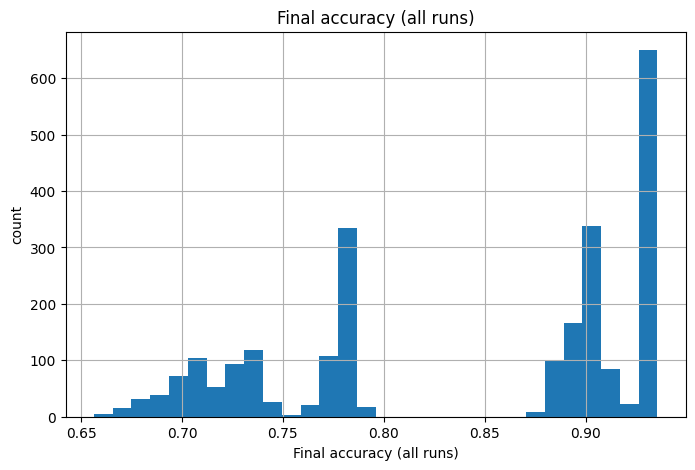

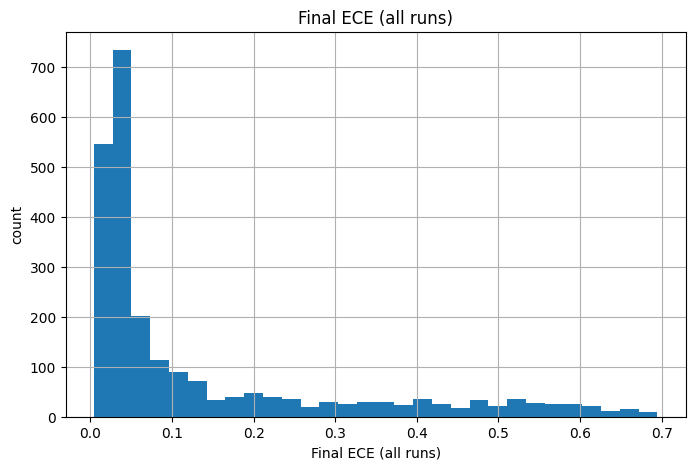

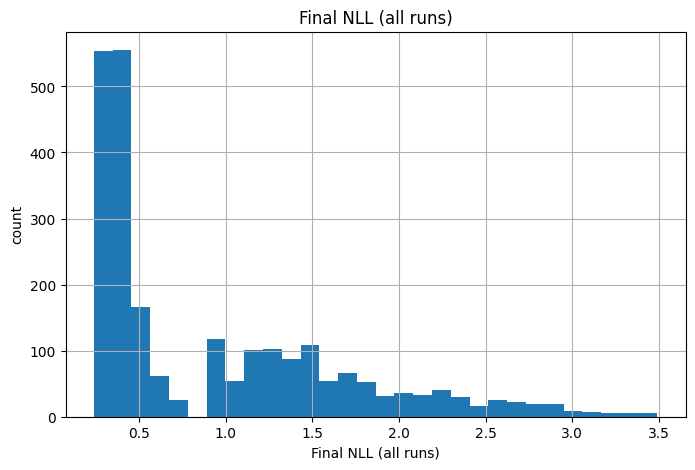

In [6]:
# ==== Quick plots (acc, ece, nll where present) ==============================
def _safe_hist(series, title, bins=30):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        print(f"[skip] No data for {title}")
        return
    plt.figure()
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel("count")
    plt.show()

_safe_hist(DF["acc"], "Final accuracy (all runs)")
_safe_hist(DF["ece"], "Final ECE (all runs)")
_safe_hist(DF["nll"], "Final NLL (all runs)")


### --- Duplicate report: which hyperparameter configurations have 2+ finished runs ---

In [7]:
KEYS = ["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]
dup_counts = DF.groupby(KEYS, dropna=False).size().rename("n_runs").reset_index()
dups = dup_counts[dup_counts["n_runs"] > 1].sort_values("n_runs", ascending=False)

print(f"Configs with n_runs > 1: {len(dups)}")
display(dups.head(30))

# Optional: list all duplicated tuples and their run_ids
if not dups.empty:
    merged = DF.merge(dups[KEYS], on=KEYS, how="inner")
    print("Sample of duplicated tuples with run_ids:")
    display(merged.sort_values(KEYS + ["run_id"]).head(50))


Configs with n_runs > 1: 25


,dataset,pretrained,batch_size,num_vb_iters,seed,epochs,n_runs
0,cifar10,in21k,512,1,0,5,2
2,cifar10,in21k,512,1,1,5,2
4,cifar10,in21k,512,1,2,5,2
6,cifar10,in21k,512,1,3,5,2
8,cifar10,in21k,512,1,4,5,2
12,cifar10,in21k,512,2,0,5,2
14,cifar10,in21k,512,2,1,5,2
16,cifar10,in21k,512,2,2,5,2
18,cifar10,in21k,512,2,3,5,2
20,cifar10,in21k,512,2,4,5,2


Sample of duplicated tuples with run_ids:


,dataset,seed,batch_size,num_vb_iters,pretrained,group_id,run_id,name,state,acc,nll,ece,loss,epoch,_runtime,_step,_exit_code,epochs,nodataaug
45,cifar10,0,512,1,in21k,sweep2_batchsize_numiters,2anvkdfn,fiery-universe-645,finished,0.9075,0.564856,0.124072,0.543296,5,69,9,NaN,5,True
8,cifar10,0,512,1,in21k,sweep2_batchsize_numiters,eo7dk4q4,worthy-silence-696,finished,0.9075,0.564856,0.124072,0.543296,5,118,9,NaN,5,True
7,cifar10,1,512,1,in21k,sweep2_batchsize_numiters,xvoqyrm5,cool-moon-696,finished,0.9079,0.545751,0.122452,0.528743,5,118,9,NaN,5,True
49,cifar10,1,512,1,in21k,sweep2_batchsize_numiters,zwjagwct,hardy-wildflower-645,finished,0.9079,0.545751,0.122452,0.528743,5,71,9,NaN,5,True
2,cifar10,2,512,1,in21k,sweep2_batchsize_numiters,2u0wqc5q,classic-feather-703,finished,0.9071,0.555173,0.121748,0.540697,5,117,9,NaN,5,True
43,cifar10,2,512,1,in21k,sweep2_batchsize_numiters,44l6vu5c,hearty-voice-648,finished,0.9071,0.555173,0.121748,0.540697,5,70,9,NaN,5,True
4,cifar10,3,512,1,in21k,sweep2_batchsize_numiters,5ruh4nju,floral-yogurt-698,finished,0.9079,0.569126,0.125950,0.551472,5,118,9,NaN,5,True
48,cifar10,3,512,1,in21k,sweep2_batchsize_numiters,aeqibay4,rose-sun-645,finished,0.9079,0.569126,0.125950,0.551472,5,69,9,NaN,5,True
44,cifar10,4,512,1,in21k,sweep2_batchsize_numiters,f7ooj130,dazzling-sponge-645,finished,0.9075,0.549302,0.123650,0.535450,5,71,9,NaN,5,True
9,cifar10,4,512,1,in21k,sweep2_batchsize_numiters,irorgzpb,deep-darkness-696,finished,0.9075,0.549302,0.123650,0.535450,5,115,9,NaN,5,True


### Grid completeness check (expected vs observed configurations that were run)

In [8]:
# --- Define the expected grid exactly as your sweep2 file ---
DATASETS    = ["cifar10", "cifar100"]
PRETRAINED  = ["in21k", "in21k_cifar"]
BATCH_SIZES = [512, 1024, 2048, 4096, 8192, 16384, 30000]
SEEDS       = [0, 1, 2, 3, 4]

VB_OFF = [1, 2, 4, 8, 16, 32, 48, 64, 96, 128]   # epochs=5
VB_ON  = [1, 2, 4, 8, 16, 32]                    # epochs=20

import itertools
# OFF grid
off = pd.DataFrame(
    list(itertools.product(DATASETS, PRETRAINED, BATCH_SIZES, VB_OFF, SEEDS, [5])),
    columns=["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]
)
# ON grid
on  = pd.DataFrame(
    list(itertools.product(DATASETS, PRETRAINED, BATCH_SIZES, VB_ON, SEEDS, [20])),
    columns=["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]
)
EXPECTED = pd.concat([off, on], ignore_index=True)
EXPECTED["batch_size"]   = pd.to_numeric(EXPECTED["batch_size"])
EXPECTED["num_vb_iters"] = pd.to_numeric(EXPECTED["num_vb_iters"])
EXPECTED["seed"]         = pd.to_numeric(EXPECTED["seed"])
EXPECTED["epochs"]       = pd.to_numeric(EXPECTED["epochs"])

print("Expected total tuples:", len(EXPECTED))  # should be 2240

# Observed unique (finished only) by the same keys
OBS_UNIQUE = DF.drop_duplicates(subset=["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]).copy()

# LEFT join to find missing expected tuples
EXPECTED_MARK = EXPECTED.merge(
    OBS_UNIQUE.assign(_seen=1),
    on=["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"],
    how="left"
)
MISSING = EXPECTED_MARK[EXPECTED_MARK["_seen"].isna()].drop(columns=["_seen"])

print(f"Missing finished tuples from the expected grid: {len(MISSING)}")
display(MISSING.head(80))

# --- Collapse missing across seeds (but keep other axes) ---
COLLAPSE_KEYS = ["dataset","pretrained","batch_size","num_vb_iters","epochs"]

MISSING_COLLAPSED = (
    MISSING
    .drop_duplicates(subset=COLLAPSE_KEYS)
    .sort_values(COLLAPSE_KEYS)
    .reset_index(drop=True)
)

print(f"Unique missing configs (collapsed across seeds): {len(MISSING_COLLAPSED)}")
display(MISSING_COLLAPSED.head(30))

# Summaries: how many seeds missing per combo
missing_counts = (
    MISSING.groupby(COLLAPSE_KEYS)["seed"]
    .nunique()
    .reset_index()
    .rename(columns={"seed":"n_seeds_missing"})
    .sort_values("n_seeds_missing", ascending=False)
)
print("Missing counts per combo (number of seeds absent):")
display(missing_counts.head(30))


Expected total tuples: 2240
Missing finished tuples from the expected grid: 80


,dataset,pretrained,batch_size,num_vb_iters,seed,epochs,group_id,run_id,name,state,acc,nll,ece,loss,epoch,_runtime,_step,_exit_code,nodataaug
1050,cifar100,in21k_cifar,512,1,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051,cifar100,in21k_cifar,512,1,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1052,cifar100,in21k_cifar,512,1,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1053,cifar100,in21k_cifar,512,1,3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1054,cifar100,in21k_cifar,512,1,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,cifar100,in21k_cifar,30000,32,3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,cifar100,in21k,16384,4,0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,cifar100,in21k,16384,8,2,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,cifar100,in21k,16384,8,3,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unique missing configs (collapsed across seeds): 22


,dataset,pretrained,batch_size,num_vb_iters,seed,epochs,group_id,run_id,name,state,acc,nll,ece,loss,epoch,_runtime,_step,_exit_code,nodataaug
0,cifar100,in21k,16384,4,0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cifar100,in21k,16384,8,2,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cifar100,in21k_cifar,512,1,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cifar100,in21k_cifar,512,2,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cifar100,in21k_cifar,512,4,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,cifar100,in21k_cifar,512,8,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,cifar100,in21k_cifar,512,16,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,cifar100,in21k_cifar,512,32,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,cifar100,in21k_cifar,512,48,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,cifar100,in21k_cifar,512,64,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing counts per combo (number of seeds absent):


,dataset,pretrained,batch_size,num_vb_iters,epochs,n_seeds_missing
3,cifar100,in21k_cifar,512,2,5,5
2,cifar100,in21k_cifar,512,1,5,5
4,cifar100,in21k_cifar,512,4,5,5
5,cifar100,in21k_cifar,512,8,5,5
7,cifar100,in21k_cifar,512,32,5,5
6,cifar100,in21k_cifar,512,16,5,5
10,cifar100,in21k_cifar,512,96,5,5
11,cifar100,in21k_cifar,512,128,5,5
8,cifar100,in21k_cifar,512,48,5,5
9,cifar100,in21k_cifar,512,64,5,5


In [9]:


# RIGHT-ONLY (extras): observed tuples that are not part of the intended grid
OBS_MARK = OBS_UNIQUE.merge(
    EXPECTED.assign(_expected=1),
    on=["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"],
    how="left"
)
EXTRAS = OBS_MARK[OBS_MARK["_expected"].isna()].drop(columns=["_expected"])

print(f"Observed tuples outside the intended grid: {len(EXTRAS)}")
display(EXTRAS.head(30))

# Quick summaries
if not MISSING.empty:
    print("\nMissing breakdown by dataset/pretrained (top 20):")
    display(MISSING.groupby(["dataset","pretrained"]).size().rename("n_missing").reset_index().sort_values("n_missing", ascending=False).head(20))

if not EXTRAS.empty:
    print("\nExtras breakdown by dataset/pretrained (top 20):")
    display(EXTRAS.groupby(["dataset","pretrained"]).size().rename("n_extras").reset_index().sort_values("n_extras", ascending=False).head(20))


Observed tuples outside the intended grid: 224


,dataset,seed,batch_size,num_vb_iters,pretrained,group_id,run_id,name,state,acc,nll,ece,loss,epoch,_runtime,_step,_exit_code,epochs,nodataaug
2160,cifar10,137,30000,4,in21k_cifar,sweep2_batchsize_numiters,0q4wvb9y,rich-sound-560,finished,0.9323,0.340612,0.012548,0.588188,20,240,39,NaN,20,False
2161,cifar10,137,30000,32,in21k_cifar,sweep2_batchsize_numiters,gr4xh7v8,sweet-sound-560,finished,0.9302,0.254172,0.030841,0.485451,20,237,39,NaN,20,False
2162,cifar10,137,30000,8,in21k_cifar,sweep2_batchsize_numiters,n85l1etw,earnest-haze-558,finished,0.9321,0.285892,0.011644,0.525025,20,237,39,NaN,20,False
2163,cifar10,137,30000,16,in21k_cifar,sweep2_batchsize_numiters,7ugqlo9u,ethereal-salad-558,finished,0.9314,0.257825,0.022034,0.489345,20,239,39,NaN,20,False
2164,cifar10,137,16384,16,in21k_cifar,sweep2_batchsize_numiters,cc4zxx75,crisp-frost-556,finished,0.9313,0.267296,0.025924,0.491405,20,254,39,NaN,20,False
2165,cifar10,137,8192,32,in21k_cifar,sweep2_batchsize_numiters,xtf2gav6,glorious-totem-554,finished,0.9281,0.282269,0.033065,0.506077,20,264,39,NaN,20,False
2166,cifar10,137,16384,1,in21k_cifar,sweep2_batchsize_numiters,td16ol3z,warm-wildflower-554,finished,0.9316,0.483313,0.085151,0.739649,20,252,39,NaN,20,False
2167,cifar10,137,16384,8,in21k_cifar,sweep2_batchsize_numiters,g7fno3cc,resilient-fire-552,finished,0.9308,0.287683,0.014981,0.512406,20,249,39,NaN,20,False
2168,cifar10,137,30000,1,in21k_cifar,sweep2_batchsize_numiters,hxgrol5b,colorful-sunset-552,finished,0.9314,0.595866,0.147750,0.852048,20,241,39,NaN,20,False
2169,cifar10,137,16384,32,in21k_cifar,sweep2_batchsize_numiters,17rs2568,ruby-forest-551,finished,0.9296,0.269779,0.031372,0.494291,20,253,39,NaN,20,False



Missing breakdown by dataset/pretrained (top 20):


,dataset,pretrained,n_missing
1,cifar100,in21k_cifar,77
0,cifar100,in21k,3



Extras breakdown by dataset/pretrained (top 20):


,dataset,pretrained,n_extras
0,cifar10,in21k,112
1,cifar10,in21k_cifar,112


### Coverage gaps — heatmaps of missing seeds per (batch_size × num_vb_iters)


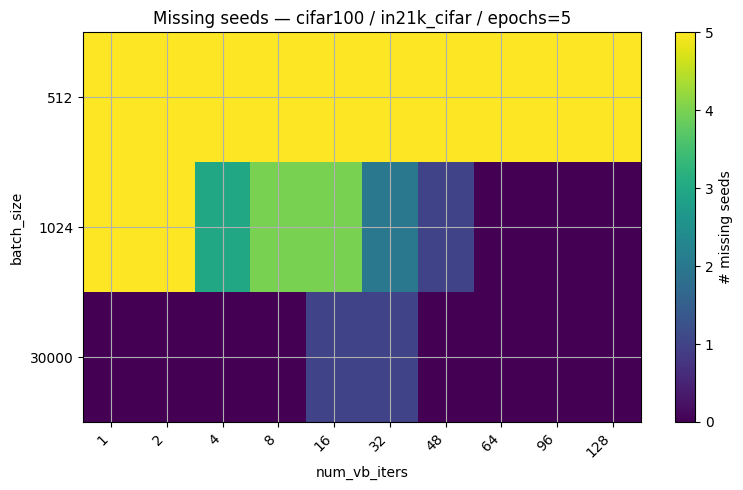

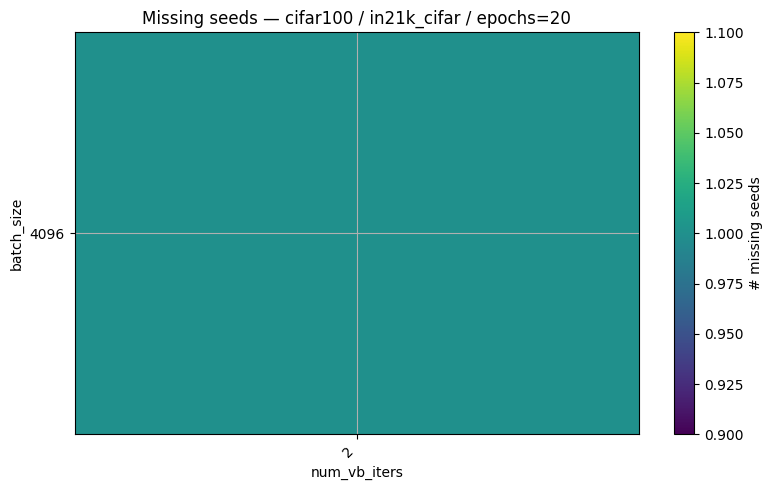

[skip] No missing entries for cifar100/in21k/epochs=5


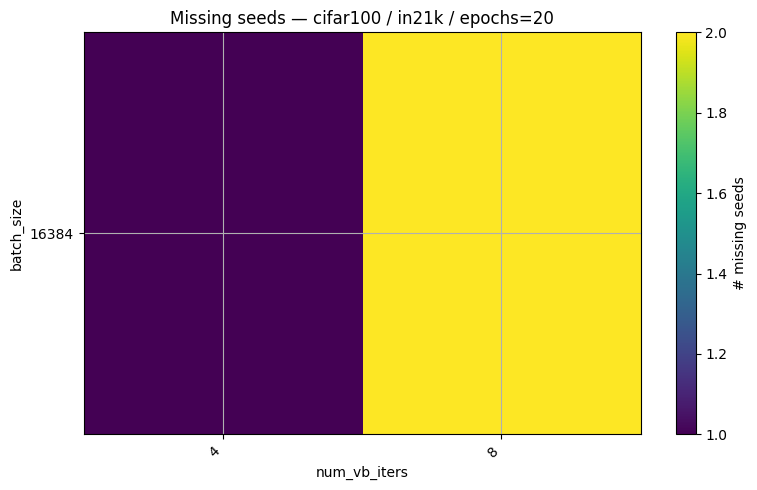

In [11]:


def heatmap_missing(df_counts, dataset, pretrained, epochs, outdir="wandb_analysis_bllarse"):
    sub = df_counts[
        (df_counts["dataset"]==dataset) &
        (df_counts["pretrained"]==pretrained) &
        (df_counts["epochs"]==epochs)
    ]
    if sub.empty:
        print(f"[skip] No missing entries for {dataset}/{pretrained}/epochs={epochs}")
        return
    # pivot to batch_size (rows) x num_vb_iters (cols)
    pivot = sub.pivot_table(index="batch_size", columns="num_vb_iters",
                            values="n_seeds_missing", fill_value=0, aggfunc="max")
    pivot = pivot.sort_index().sort_index(axis=1)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.astype(int), rotation=45, ha="right")
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.astype(int))
    ax.set_xlabel("num_vb_iters")
    ax.set_ylabel("batch_size")
    ax.set_title(f"Missing seeds — {dataset} / {pretrained} / epochs={int(epochs)}")
    fig.colorbar(im, ax=ax, label="# missing seeds")
    Path(outdir).mkdir(parents=True, exist_ok=True)
    fig.tight_layout()
    fig.savefig(Path(outdir)/f"missing_heatmap_{dataset}_{pretrained}_e{int(epochs)}.png", dpi=150)
    plt.show()

for ds in MISSING["dataset"].dropna().unique():
    for pt in MISSING["pretrained"].dropna().unique():
        for ep in sorted(MISSING["epochs"].dropna().unique()):
            heatmap_missing(missing_counts, ds, pt, ep)


### Aggregate final metrics across seeds + heatmaps

,dataset,pretrained,batch_size,num_vb_iters,epochs,acc_mean_mean,acc_mean_std,acc_mean_count,ece_mean_mean,ece_mean_std,...,nll_mean_count,acc_sem,acc_ci95_lo,acc_ci95_hi,ece_sem,ece_ci95_lo,ece_ci95_hi,nll_sem,nll_ci95_lo,nll_ci95_hi
0,cifar10,in21k,512,1,5,0.907533,0.000320,6,0.123534,0.001452,...,6,0.000131,0.907277,0.907790,0.000593,0.122372,0.124695,0.003897,0.550592,0.565866
1,cifar10,in21k,512,1,20,0.897000,0.001315,6,0.083834,0.005051,...,6,0.000537,0.895948,0.898052,0.002062,0.079793,0.087876,0.010485,0.523014,0.564116
2,cifar10,in21k,512,2,5,0.907300,0.000447,6,0.068978,0.001543,...,6,0.000183,0.906942,0.907658,0.000630,0.067744,0.070213,0.004057,0.446013,0.461917
3,cifar10,in21k,512,2,20,0.896467,0.001810,6,0.048011,0.004551,...,6,0.000739,0.895019,0.897915,0.001858,0.044370,0.051652,0.010151,0.462796,0.502587
4,cifar10,in21k,512,4,5,0.904800,0.000936,6,0.035136,0.001807,...,6,0.000382,0.904051,0.905549,0.000738,0.033689,0.036582,0.003481,0.390013,0.403659
5,cifar10,in21k,512,4,20,0.894983,0.001888,6,0.023750,0.004380,...,6,0.000771,0.893472,0.896494,0.001788,0.020245,0.027255,0.009572,0.430047,0.467569
6,cifar10,in21k,512,8,5,0.899933,0.001473,6,0.011673,0.001349,...,6,0.000601,0.898754,0.901112,0.000551,0.010593,0.012753,0.002739,0.365487,0.376223
7,cifar10,in21k,512,8,20,0.890233,0.001141,6,0.012516,0.002158,...,6,0.000466,0.889320,0.891147,0.000881,0.010789,0.014243,0.008192,0.420224,0.452335
8,cifar10,in21k,512,16,5,0.893583,0.002114,6,0.017681,0.001068,...,6,0.000863,0.891892,0.895275,0.000436,0.016826,0.018536,0.001904,0.371723,0.379187
9,cifar10,in21k,512,16,20,0.882800,0.001411,6,0.024010,0.004105,...,6,0.000576,0.881671,0.883929,0.001676,0.020725,0.027295,0.005885,0.437884,0.460954


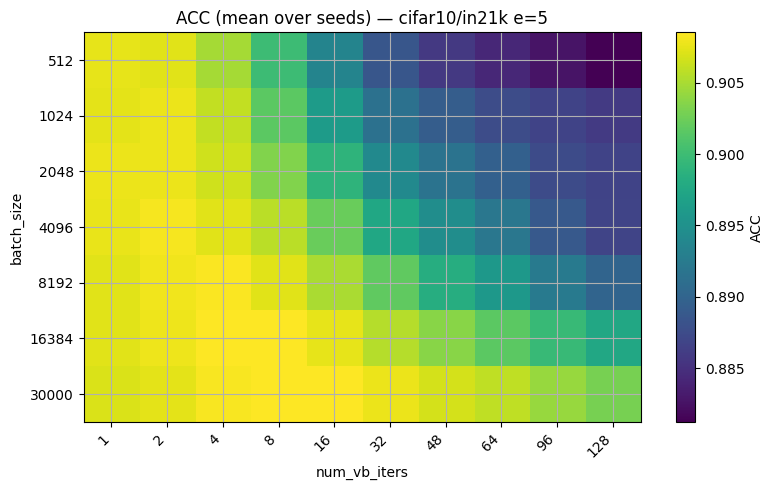

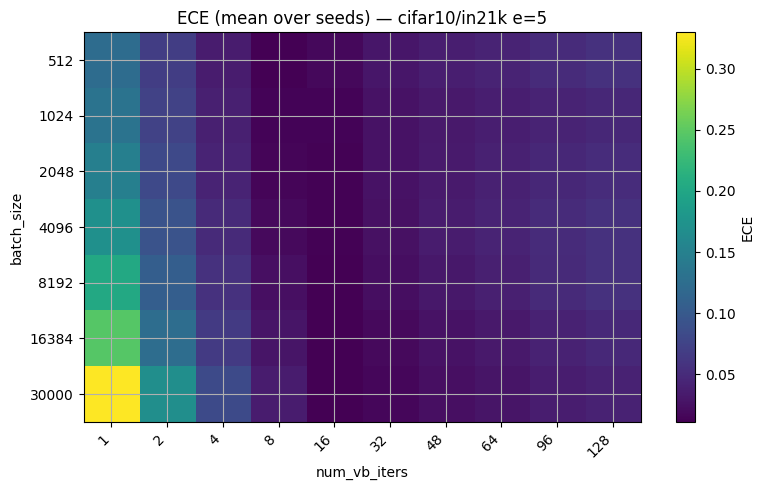

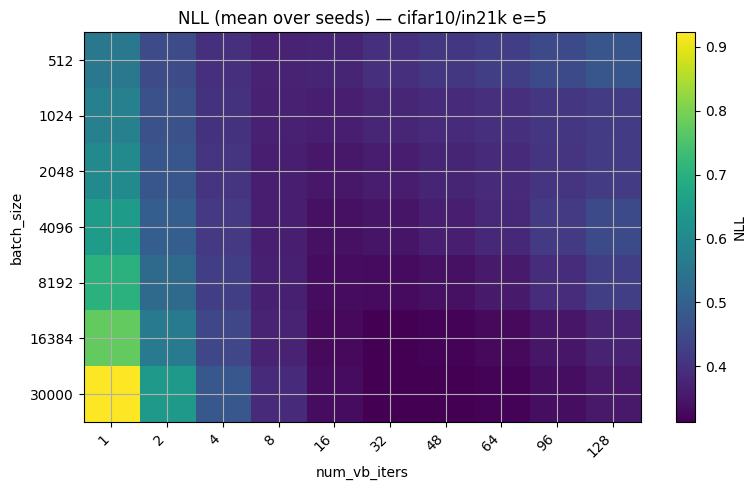

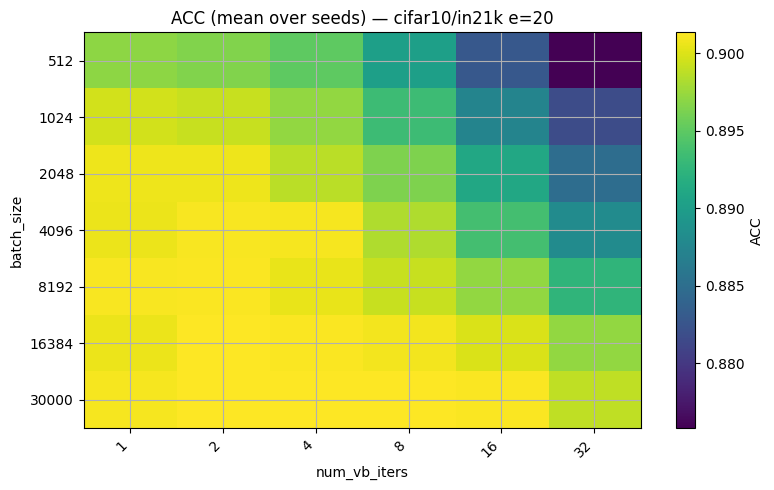

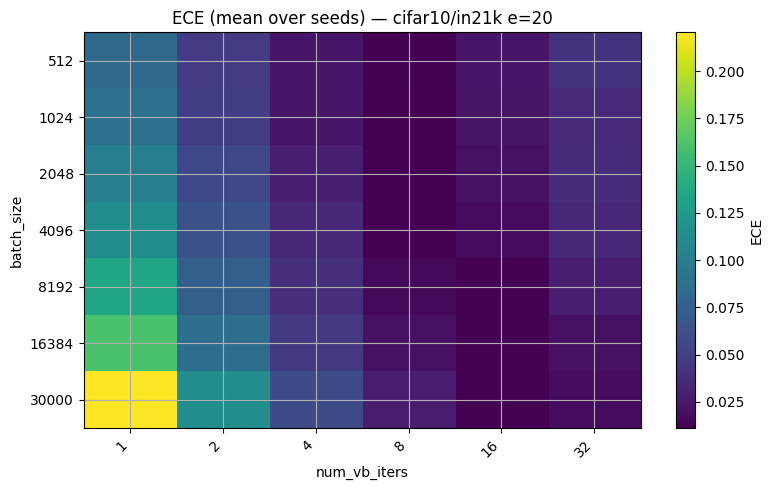

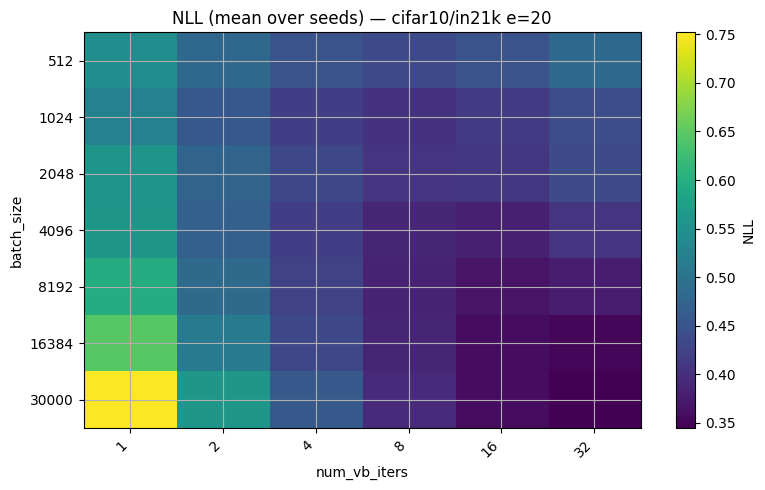

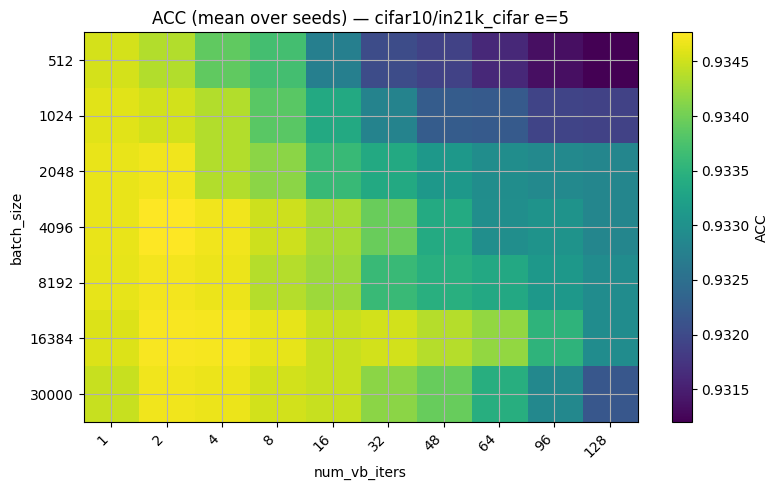

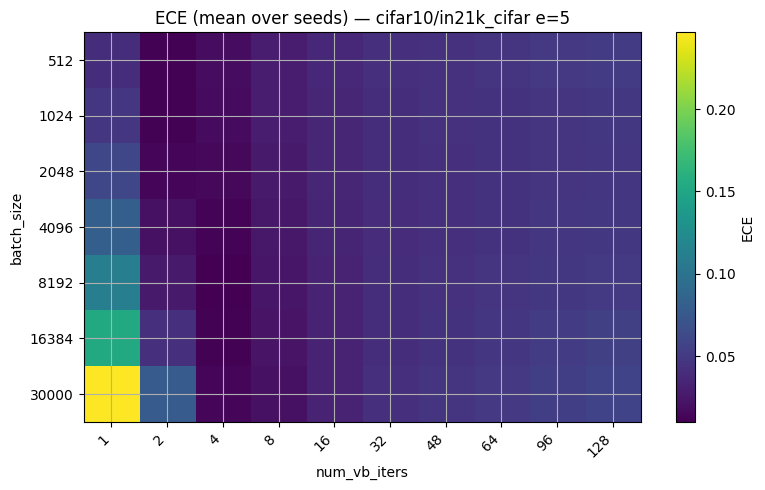

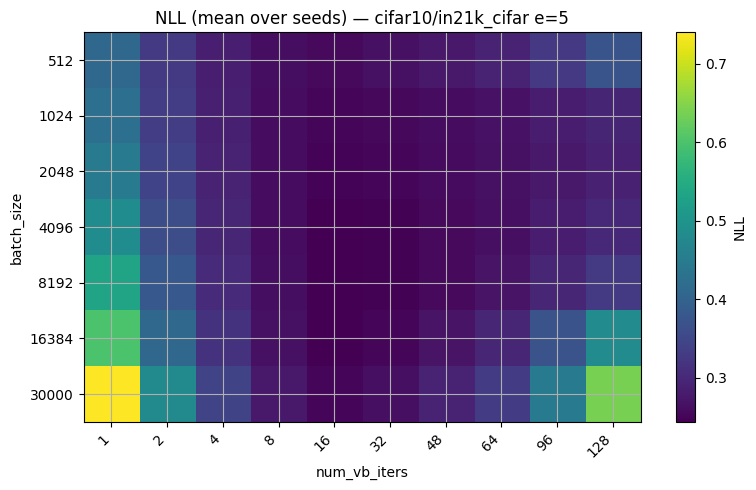

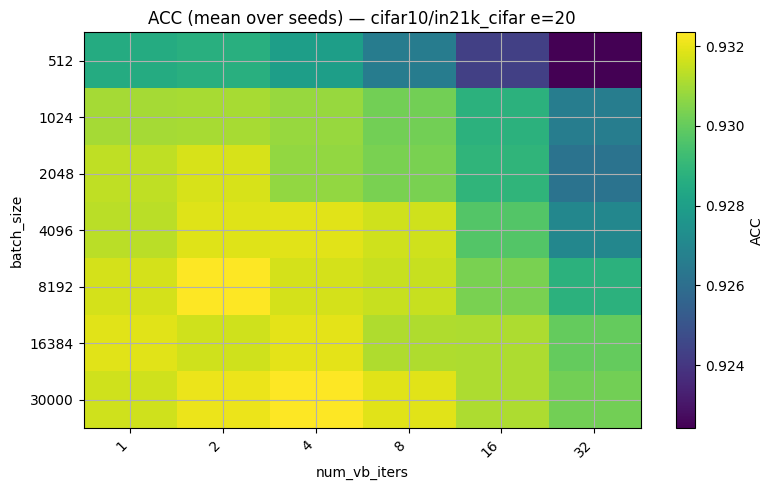

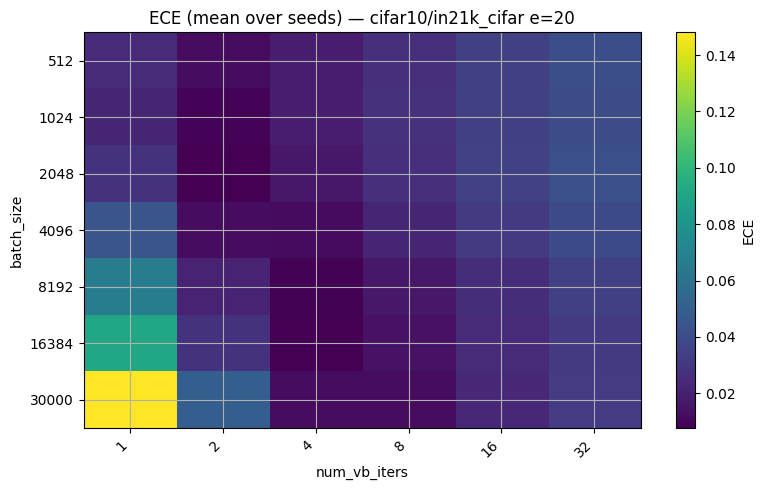

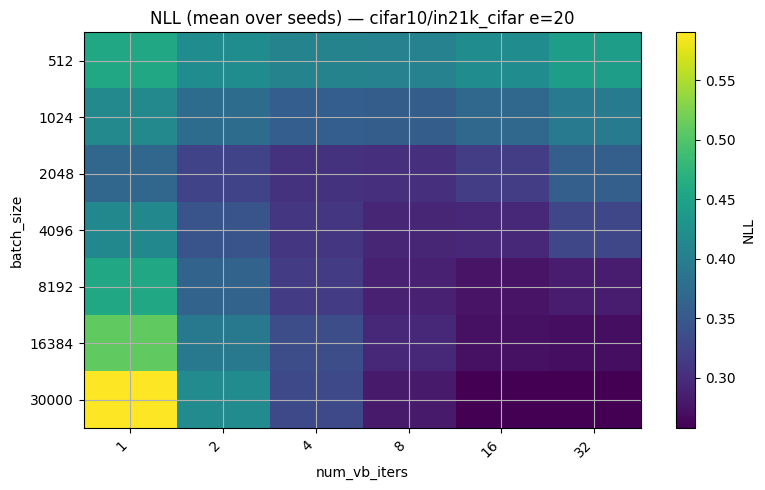

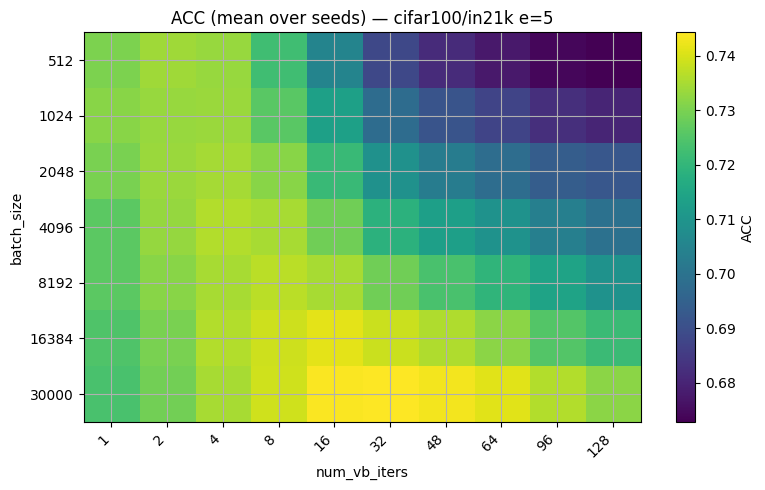

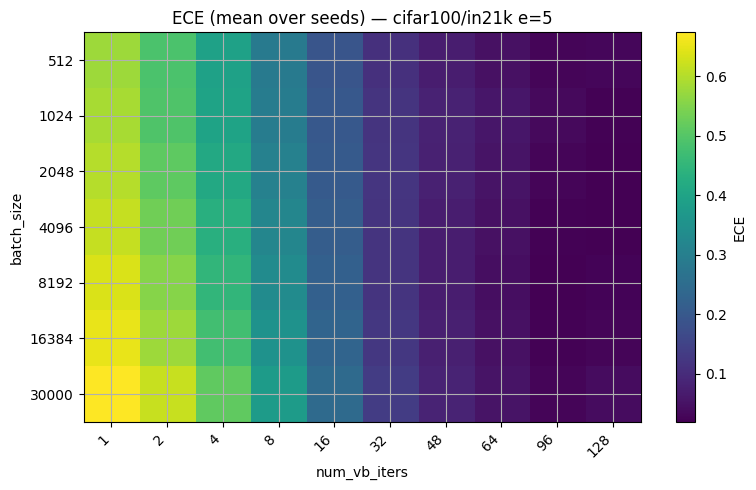

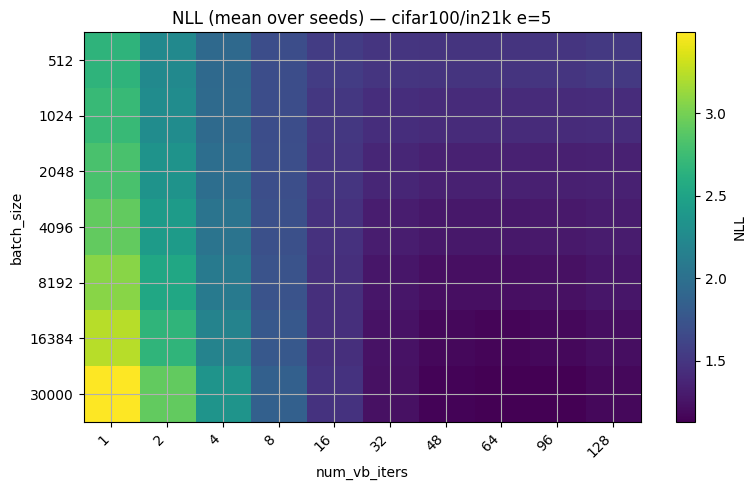

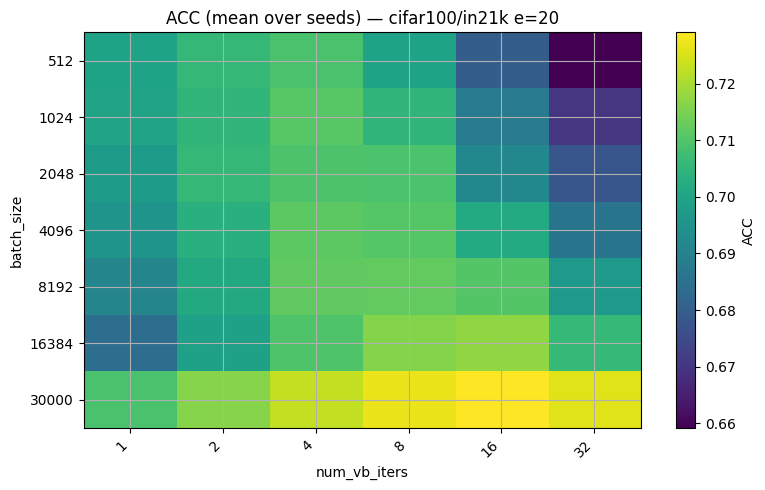

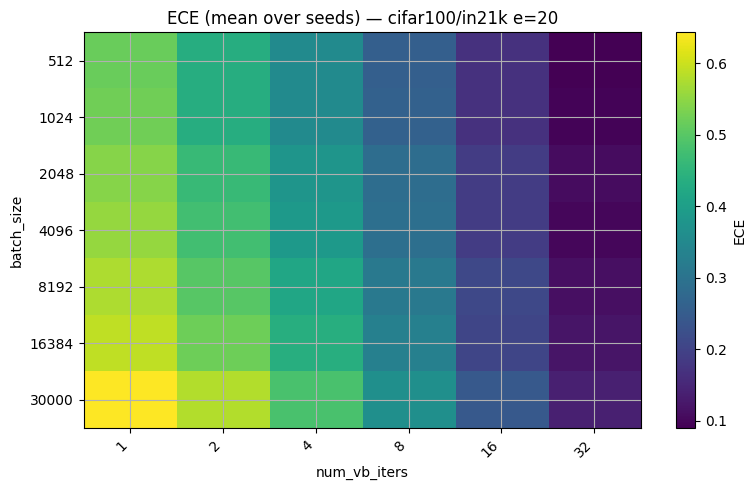

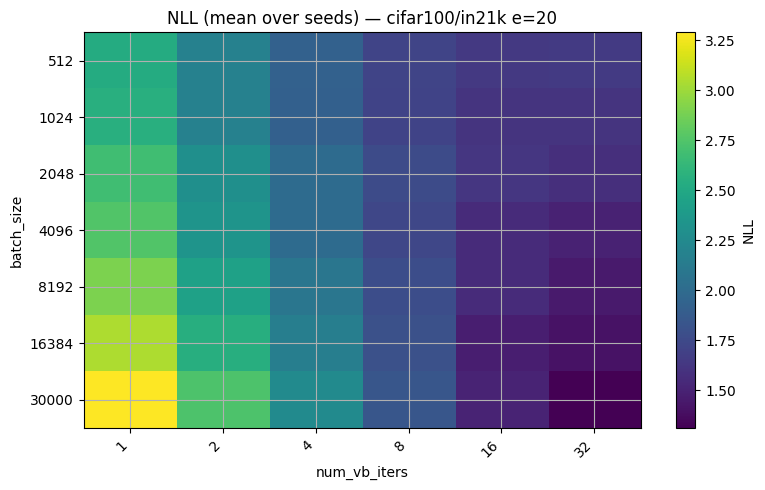

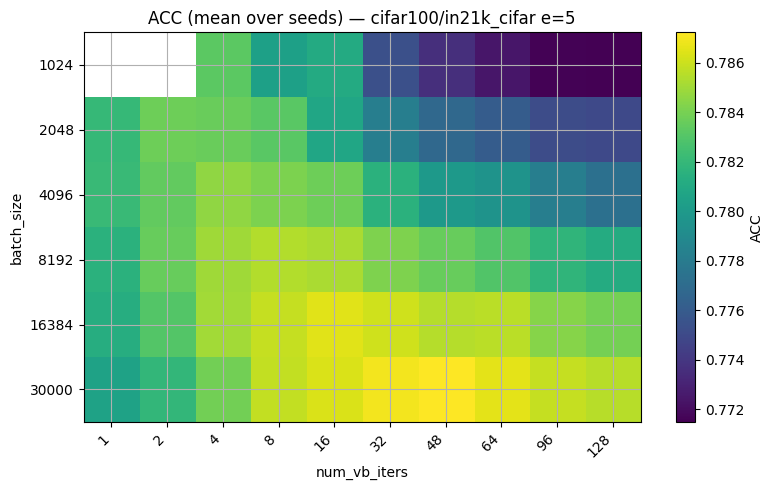

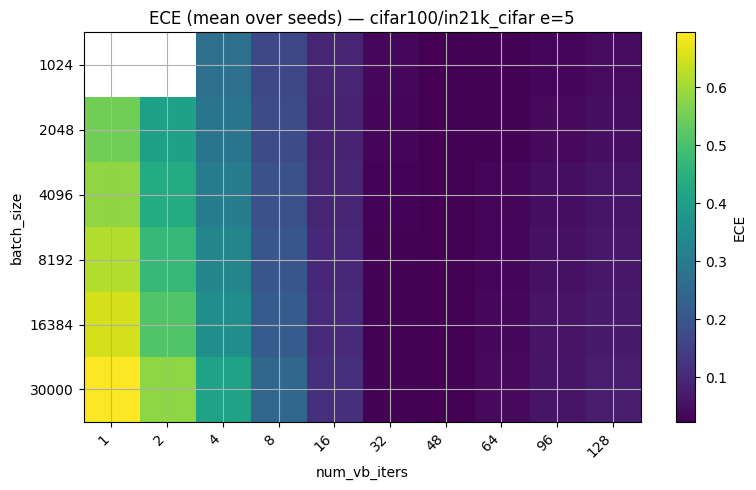

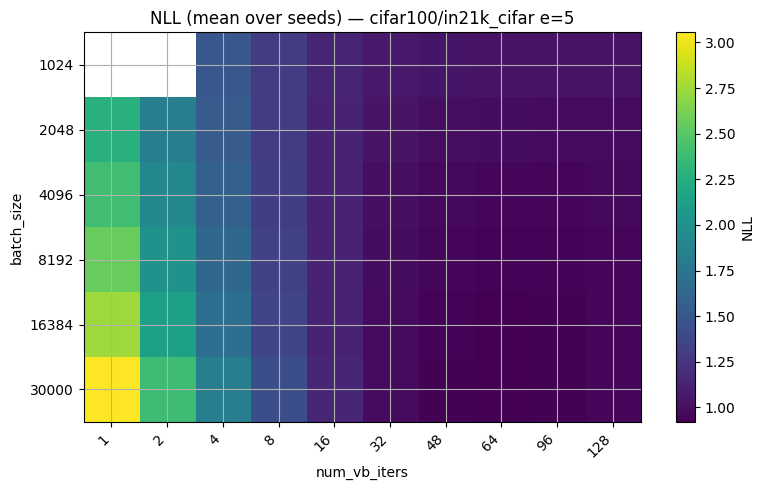

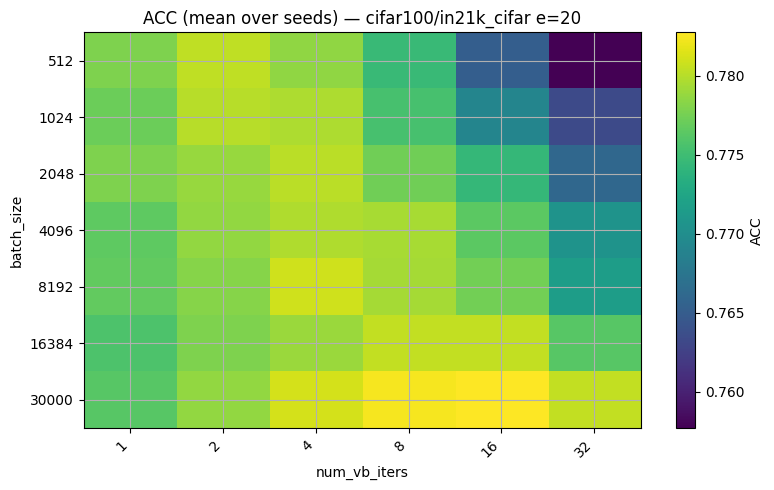

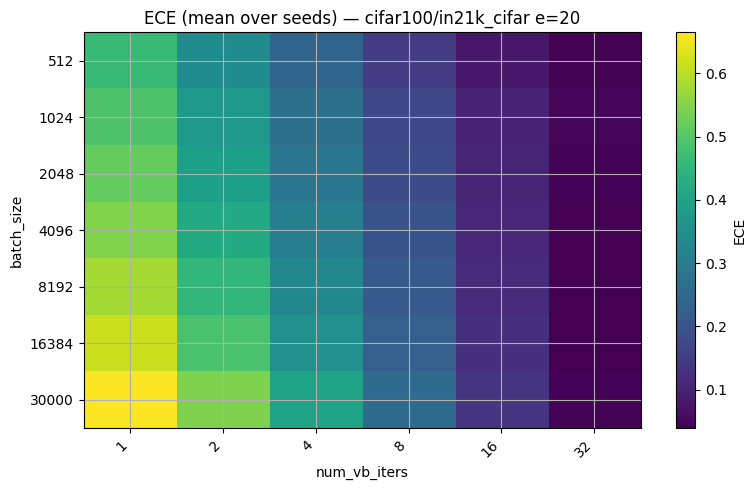

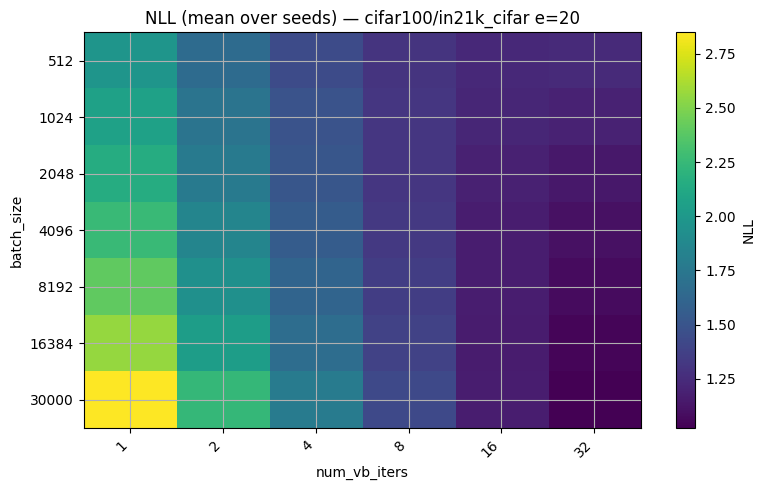

In [25]:

AGG_KEYS = ["dataset","pretrained","batch_size","num_vb_iters","epochs"]
METRICS  = ["acc","ece","nll"]

# Average within (keys + seed) in case duplicates exist, then average across seeds
per_seed = (DF.groupby(AGG_KEYS + ["seed"], dropna=False)[METRICS]
            .agg(["mean"])
            .reset_index())
per_seed.columns = ["_".join(c).strip("_") for c in per_seed.columns.values]

agg = (per_seed.groupby(AGG_KEYS, dropna=False)[[m+"_mean" for m in METRICS]]
       .agg(["mean","std","count"])
       .reset_index())
agg.columns = ["_".join([c for c in col if c]) for col in agg.columns.values]

# derive SEM and 95% CI bounds
for m in METRICS:
    mu = f"{m}_mean_mean"
    sd = f"{m}_mean_std"
    n  = f"{m}_mean_count"
    sem = f"{m}_sem"
    lo  = f"{m}_ci95_lo"
    hi  = f"{m}_ci95_hi"
    agg[sem] = agg[sd] / np.sqrt(np.clip(agg[n], 1, None))
    agg[lo]  = agg[mu] - 1.96 * agg[sem]
    agg[hi]  = agg[mu] + 1.96 * agg[sem]

Path(OUTDIR).mkdir(parents=True, exist_ok=True)
agg.to_csv(Path(OUTDIR) / "final_metrics_agg_by_cell.csv", index=False)
display(agg.head(10))

def heatmap_metric(agg_df, dataset, pretrained, epochs, metric, outdir="wandb_analysis_bllarse"):
    mu_col = f"{metric}_mean_mean"
    sub = agg_df[
        (agg_df["dataset"]==dataset) &
        (agg_df["pretrained"]==pretrained) &
        (agg_df["epochs"]==epochs)
    ]
    if sub.empty or mu_col not in sub.columns:
        print(f"[skip] No data for {dataset}/{pretrained}/epochs={epochs} metric={metric}")
        return
    pivot = sub.pivot_table(index="batch_size", columns="num_vb_iters", values=mu_col, aggfunc="mean")
    pivot = pivot.sort_index().sort_index(axis=1)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.astype(int), rotation=45, ha="right")
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.astype(int))
    ax.set_xlabel("num_vb_iters")
    ax.set_ylabel("batch_size")
    ax.set_title(f"{metric.upper()} (mean over seeds) — {dataset}/{pretrained} e={int(epochs)}")
    fig.colorbar(im, ax=ax, label=metric.upper())
    Path(outdir).mkdir(parents=True, exist_ok=True)
    fig.tight_layout()
    fig.savefig(Path(outdir)/f"metric_{metric}_{dataset}_{pretrained}_e{int(epochs)}.png", dpi=150)
    plt.show()

def heatmap_metric_at_epoch(runs, DF, dataset, pretrained, epochs, metric, target_epoch, outdir="wandb_analysis_bllarse"):
    """
    Build a batch_size × num_vb_iters heatmap of `metric` at a specific epoch,
    averaged over seeds.
    """
    KEYS = ["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]

    # Collect values per (batch_size, num_vb_iters, seed)
    rows = []
    for _, row in DF[(DF["dataset"]==dataset)&(DF["pretrained"]==pretrained)&(DF["epochs"]==epochs)].iterrows():
        seed = int(row["seed"])
        vbi  = int(row["num_vb_iters"])
        bs   = int(row["batch_size"])
        rid  = row["run_id"]

        run = next((r for r in runs if r.id == rid), None)
        if run is None:
            continue

        # Try to fetch history for the metric
        try:
            hist = run.history(keys=["epoch", metric], samples=None)
        except Exception:
            hist = None
        if hist is None or hist.empty:
            continue

        # find the row with epoch closest to target_epoch
        hist = hist.dropna(subset=[metric, "epoch"])
        if hist.empty:
            continue
        closest = hist.iloc[(hist["epoch"]-target_epoch).abs().argmin()]
        rows.append({"batch_size":bs, "num_vb_iters":vbi, "seed":seed, metric:closest[metric]})

    if not rows:
        print(f"[skip] No data for {dataset}/{pretrained}/epochs={epochs} metric={metric} at epoch {target_epoch}")
        return

    dfv = pd.DataFrame(rows)
    pivot = dfv.groupby(["batch_size","num_vb_iters"])[metric].mean().unstack()
    pivot = pivot.sort_index().sort_index(axis=1)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.astype(int), rotation=45, ha="right")
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.astype(int))
    ax.set_xlabel("num_vb_iters")
    ax.set_ylabel("batch_size")
    ax.set_title(f"{metric.upper()} at epoch {target_epoch} — {dataset}/{pretrained} e={epochs}")
    fig.colorbar(im, ax=ax, label=metric.upper())
    Path(outdir).mkdir(parents=True, exist_ok=True)
    fig.tight_layout()
    fig.savefig(Path(outdir)/f"metric_{metric}_{dataset}_{pretrained}_e{epochs}_at{target_epoch}.png", dpi=150)
    plt.show()

## TODO: Somehow the below chunk of commented code is super slow, likely due to fetching history for each run in `heatmap_metric_at_epoch`
### Seems to get tied up here: 
### hist = run.history(keys=["epoch", metric], samples=None)
### Possibly because there are many runs and each history fetch is a separate API call? 
### Could try setting MAX_POINTS_PER_RUN to a finite number, which seemed to speed up the `fetch_runs` step in the line plots below

# =============================================================================
# # Set one of these:
# # TARGET_EPOCHS = None        # -> plots FINAL (summary) heatmaps, as before
# TARGET_EPOCHS = [1]      # -> plots heatmaps at epoch 10 (across seeds)
# # TARGET_EPOCHS = [5, 10]   # -> multiple checkpoints

# # Optional: narrow to a subset to speed up
# DATASETS_TO_PLOT   = None   # e.g., ["cifar10"] or None for all
# PRETRAINED_TO_PLOT = None   # e.g., ["in21k","in21k_cifar"] or None for all
# EPOCHS_TO_PLOT     = None   # e.g., [20] or None for all present in agg["epochs"]

# def _should_plot(val, allow_list):
#     return True if allow_list is None else (val in allow_list)

# for ds in agg["dataset"].dropna().unique():
#     if not _should_plot(ds, DATASETS_TO_PLOT): 
#         continue
#     for pt in agg["pretrained"].dropna().unique():
#         if not _should_plot(pt, PRETRAINED_TO_PLOT): 
#             continue
#         for ep in sorted(agg["epochs"].dropna().unique()):
#             if not _should_plot(int(ep), EPOCHS_TO_PLOT):
#                 continue

#             if TARGET_EPOCHS is None:
#                 # FINAL heatmaps (from summaries)
#                 for metric in METRICS:
#                     heatmap_metric(agg, ds, pt, int(ep), metric)
#             else:
#                 # Heatmaps at specific epoch(s); only plot if the target <= ep
#                 for te in TARGET_EPOCHS:
#                     if te > int(ep):
#                         # skip: you can't show epoch 10 if the run only trained 5 epochs
#                         continue
#                     for metric in METRICS:
#                         heatmap_metric_at_epoch(runs, DF, ds, pt, int(ep), metric, target_epoch=int(te))
# =============================================================================

# FINAL heatmaps (from summaries)
for ds in agg["dataset"].dropna().unique():
    for pt in agg["pretrained"].dropna().unique():
        for ep in sorted(agg["epochs"].dropna().unique()):
            for metric in METRICS:
                heatmap_metric(agg, ds, pt, ep, metric)


### Metric curves over training — mean ± 95% CI across seeds

In [14]:

# ---- Select what to plot ----
CURVE_DATASET    = "cifar10"        # "cifar10" | "cifar100"
CURVE_PRETRAINED = "in21k_cifar"    # "in21k" | "in21k_cifar"
CURVE_EPOCHS     = 20               # 5 or 20

CURVE_NUM_VB_ITERS = [1, 4, 16, 32]  # pick a few VBI values
CURVE_BATCH_SIZES  = [512, 4096, 30000]  # pick a few batch sizes

CURVE_METRICS = ["acc","ece","nll"]  # which metrics to plot over epochs
MAX_POINTS_PER_RUN = 200             # thin histories client-side


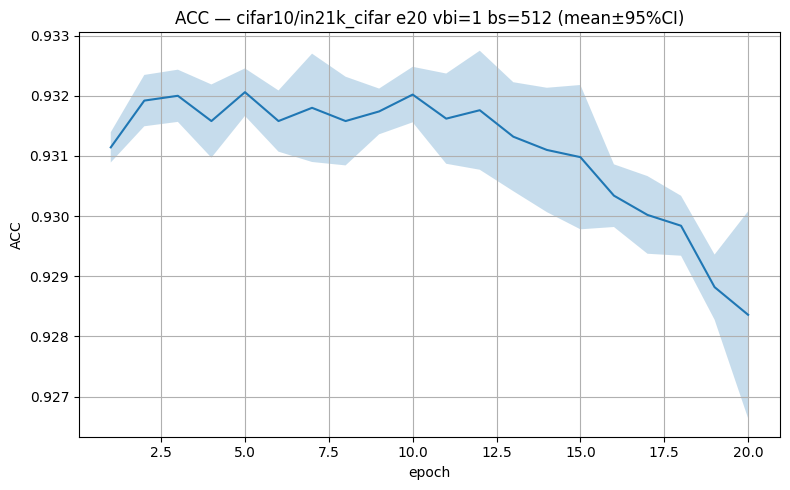

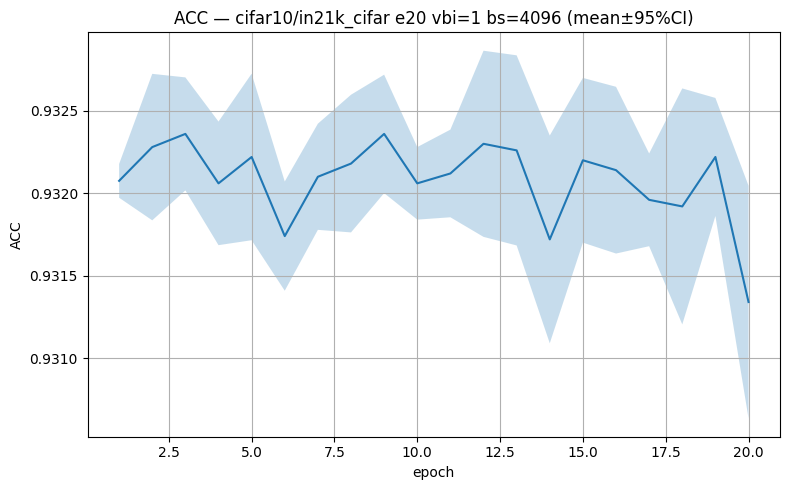

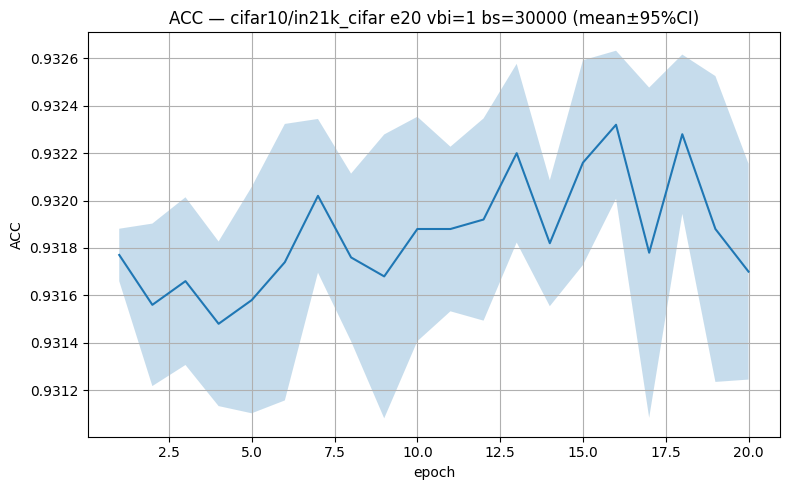

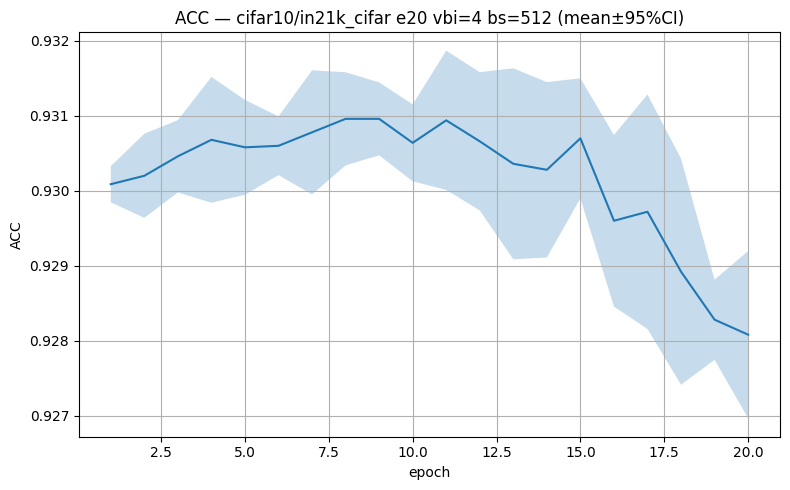

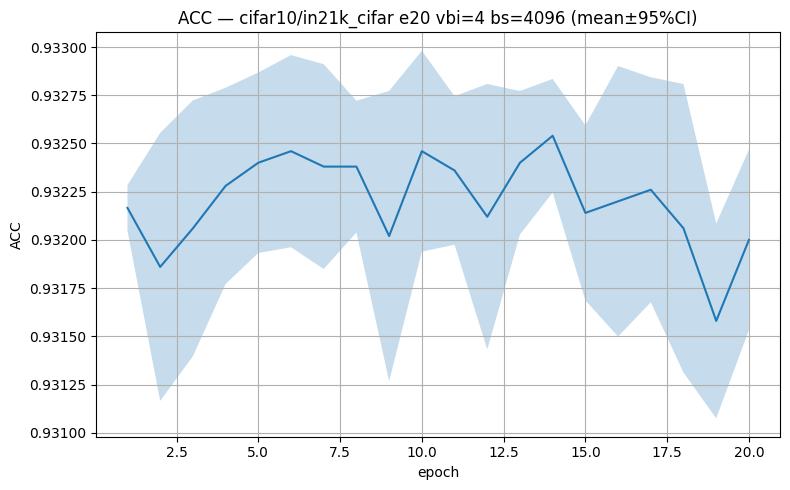

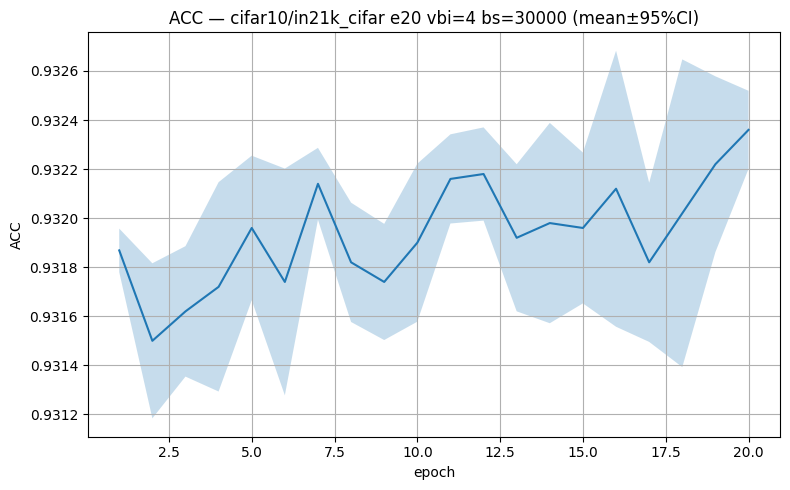

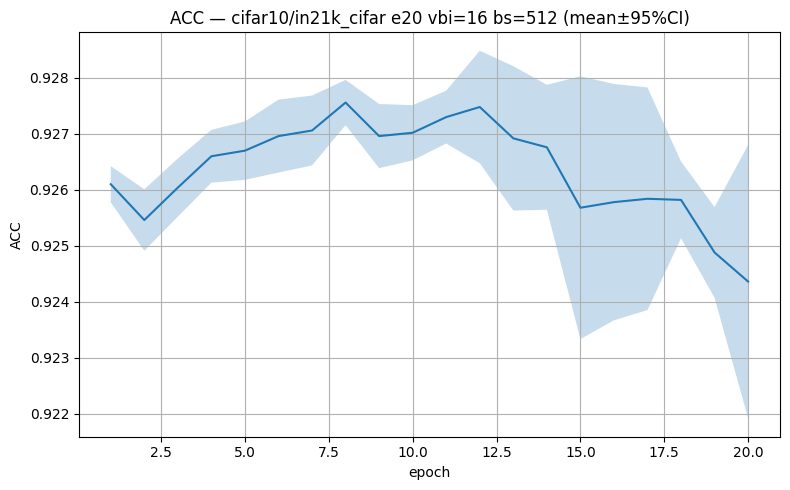

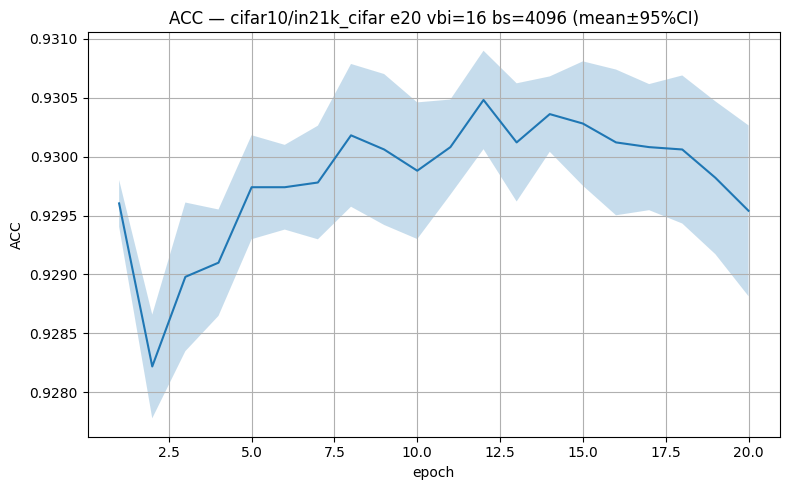

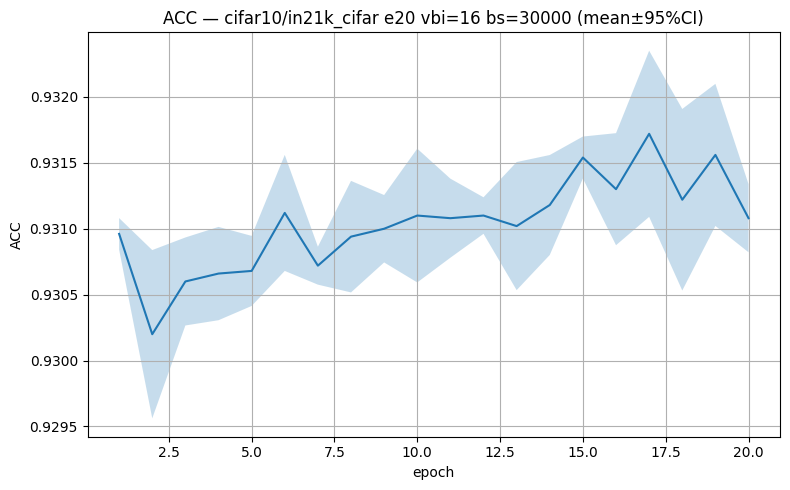

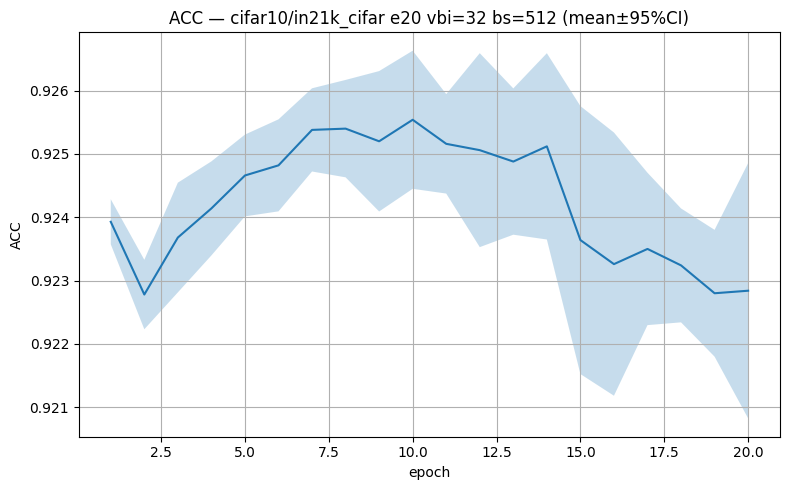

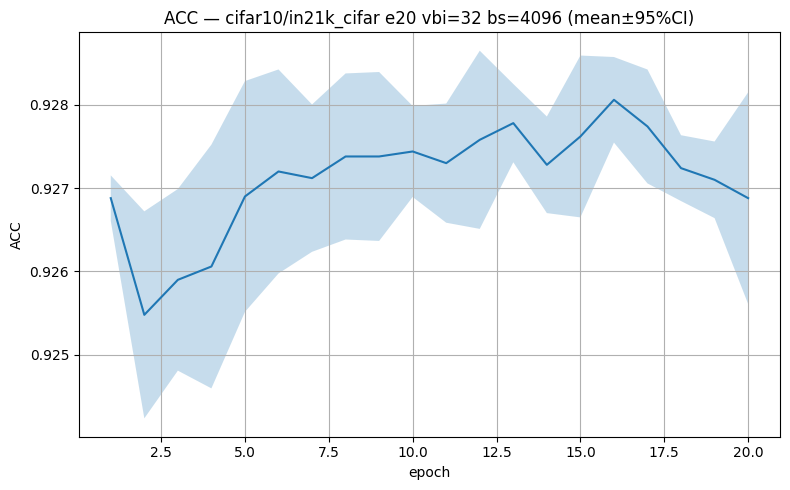

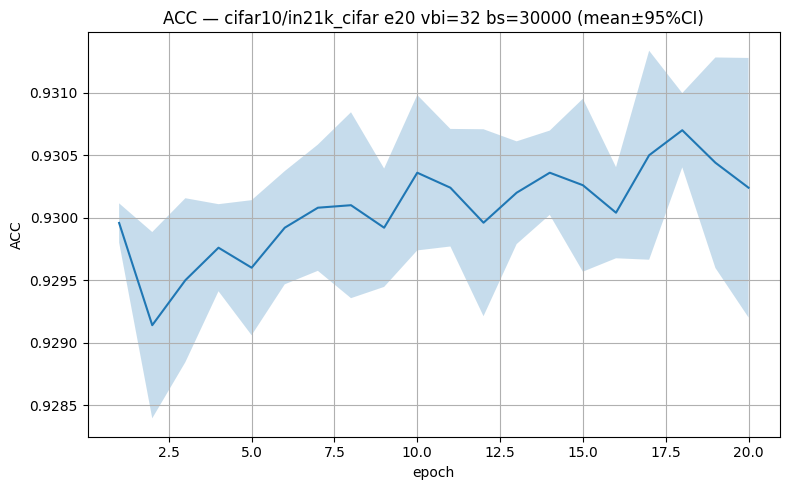

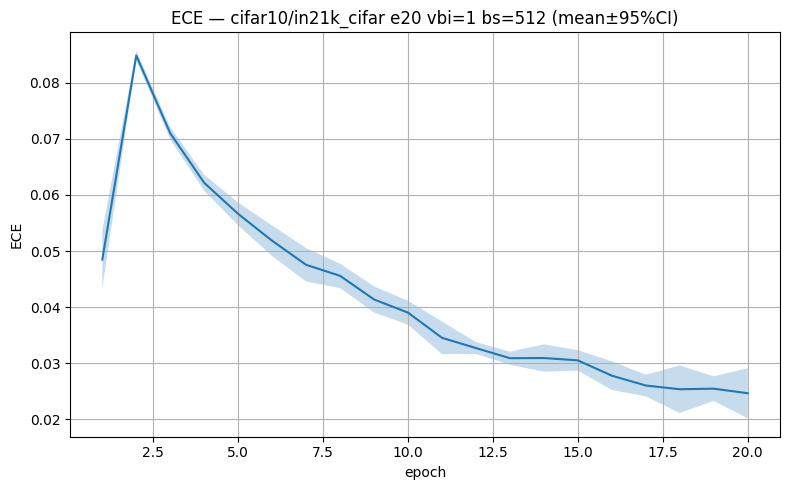

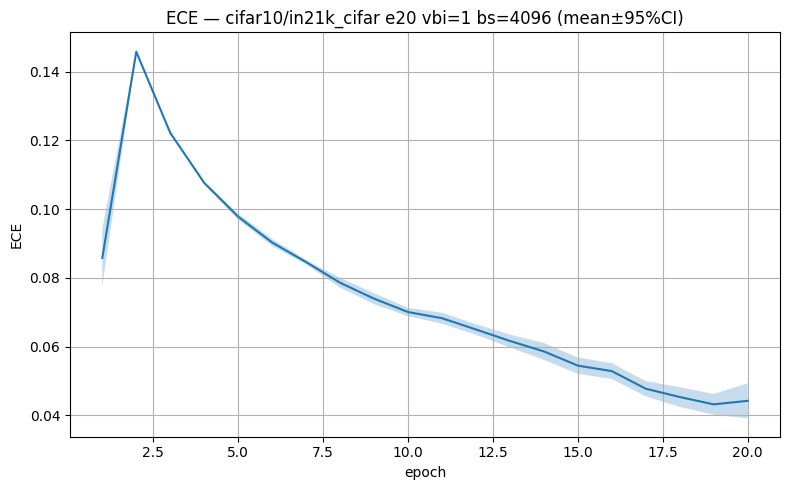

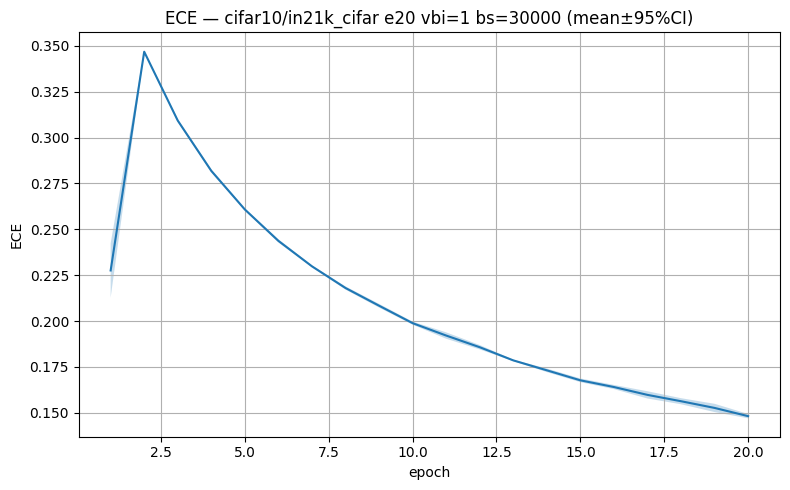

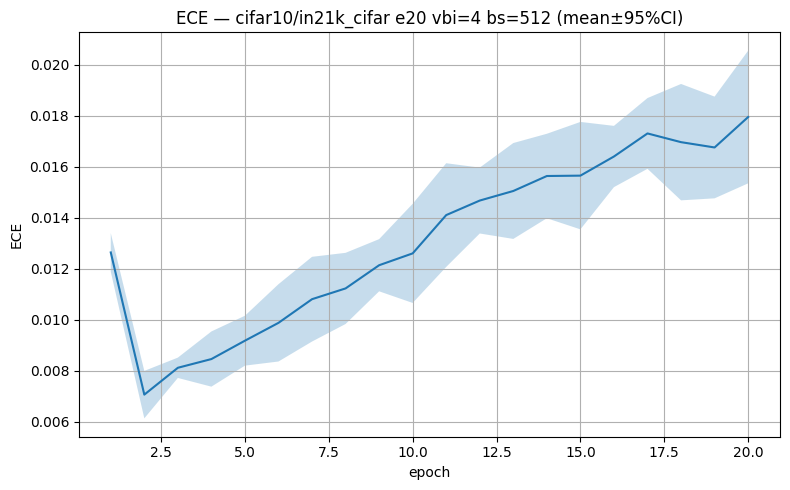

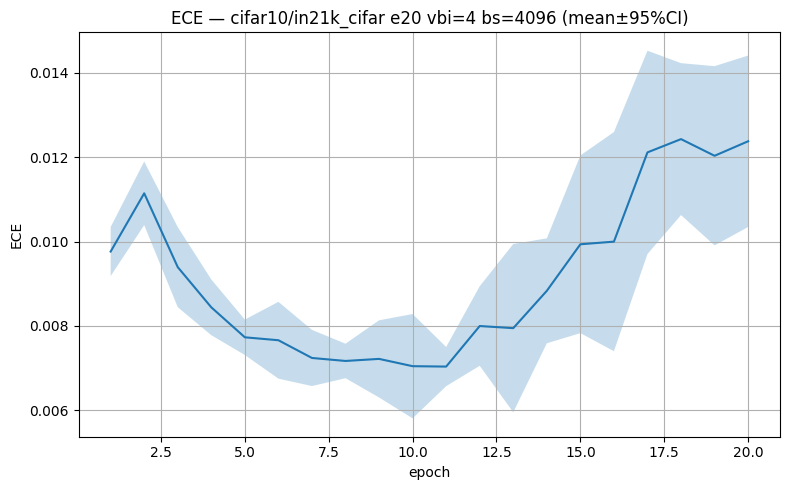

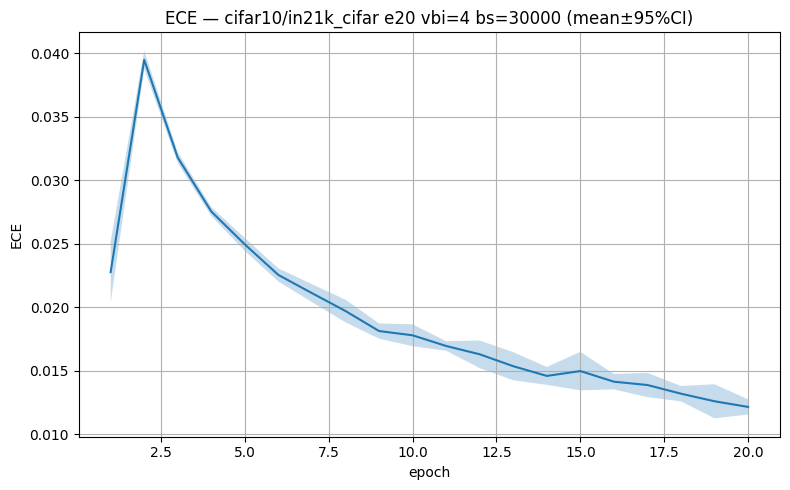

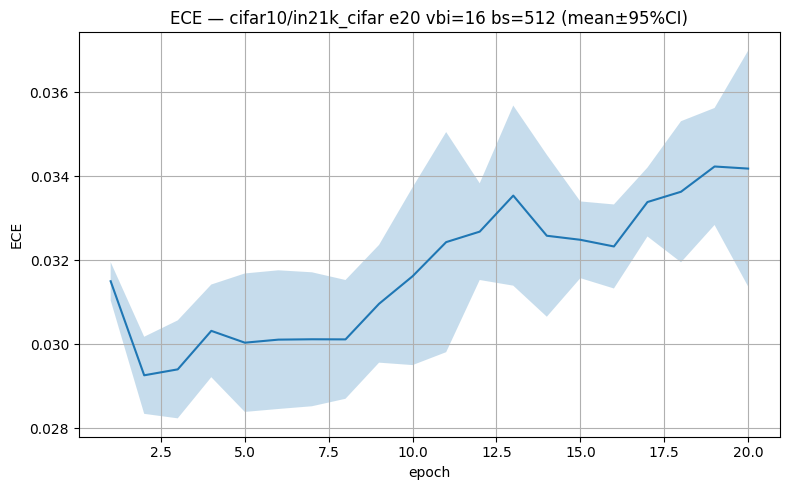

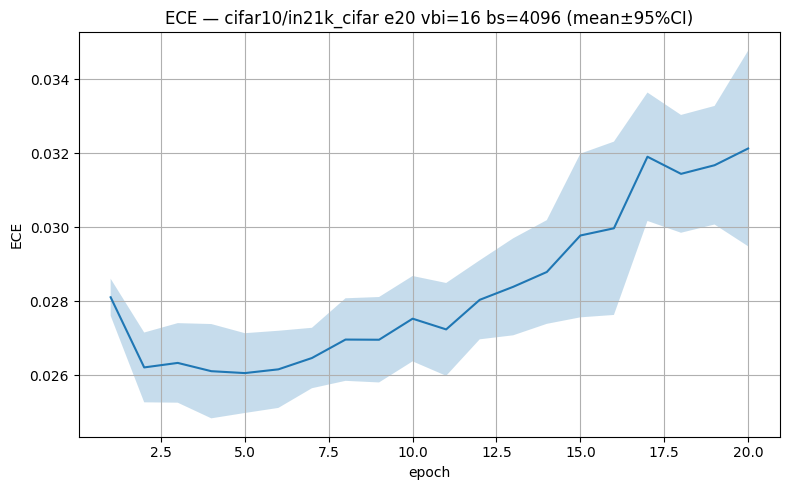

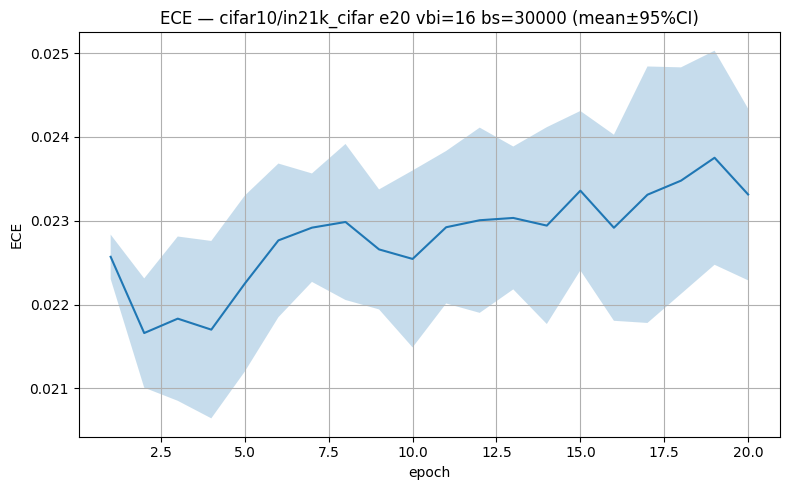

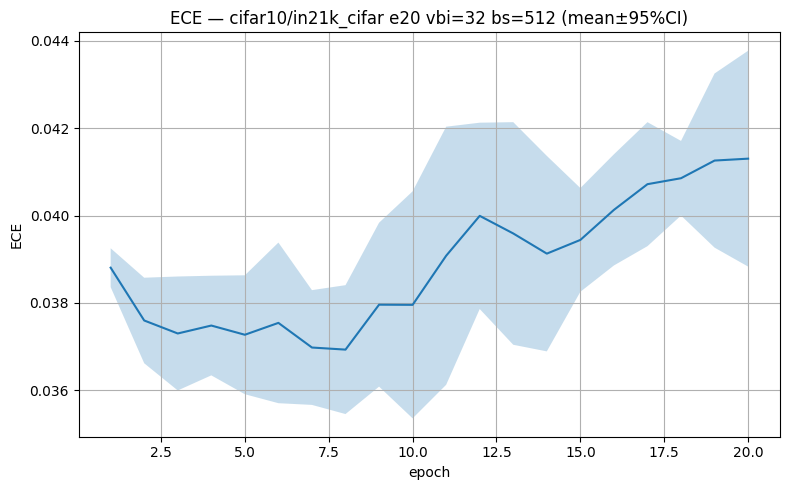

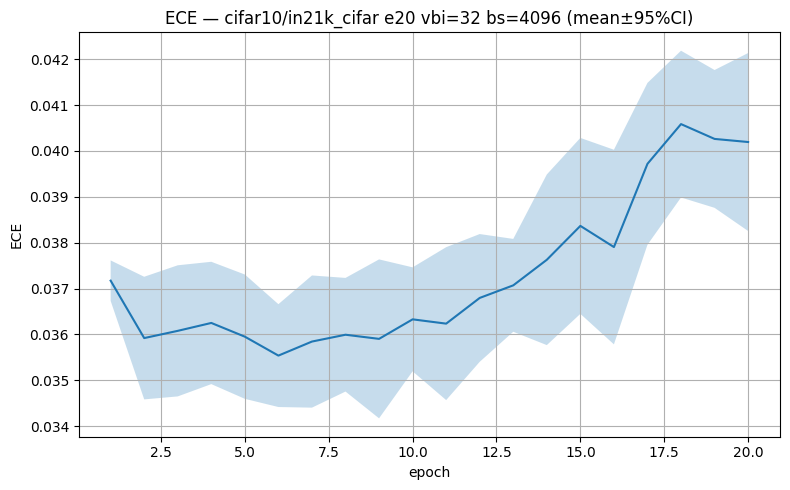

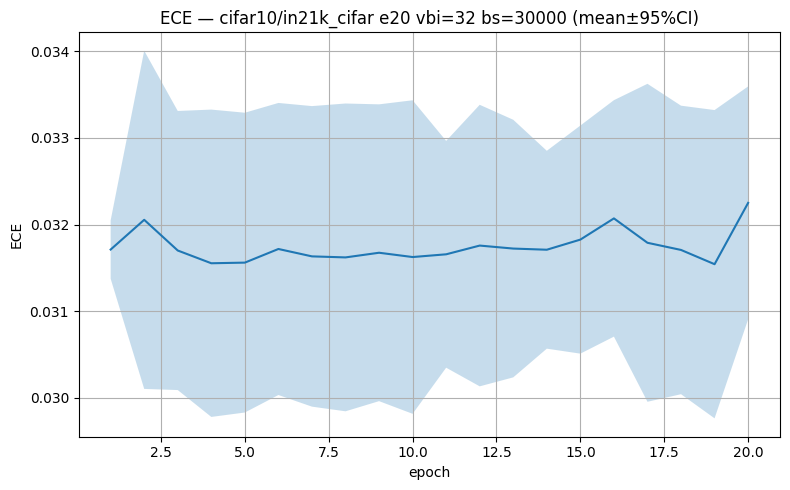

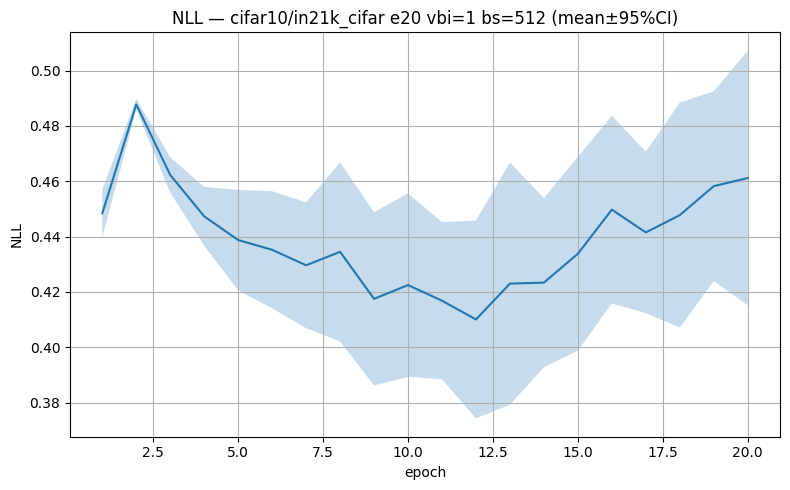

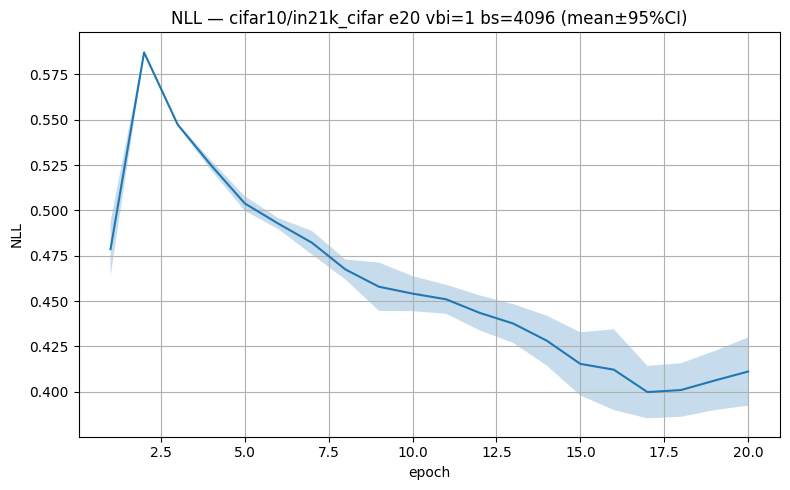

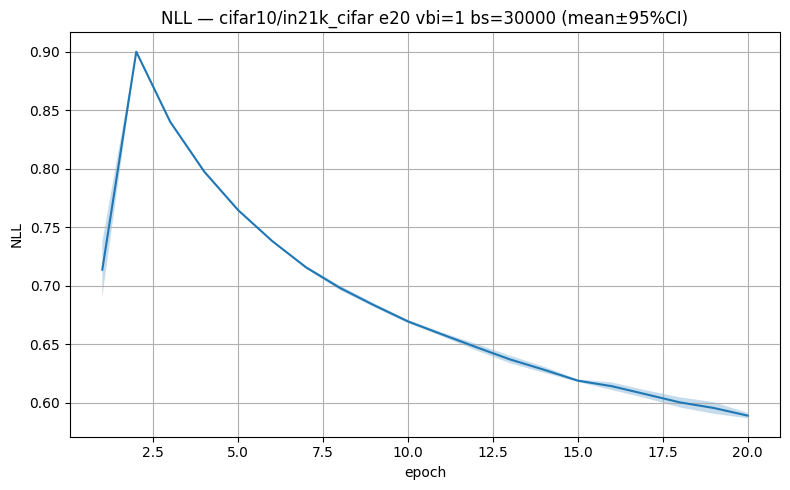

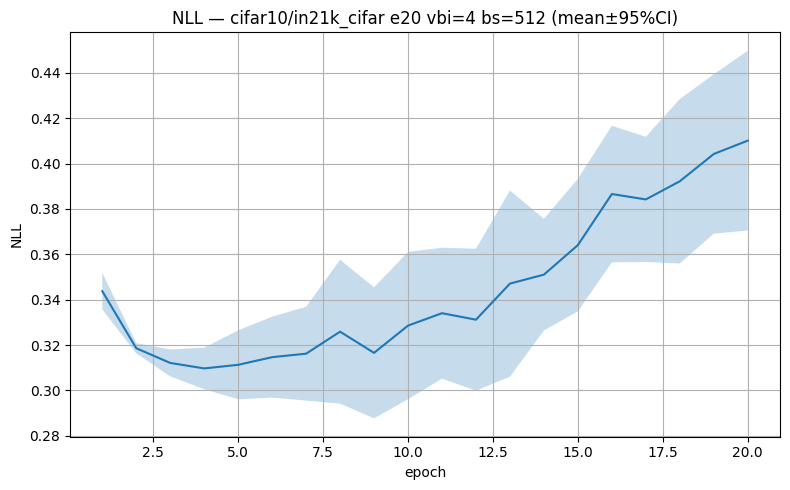

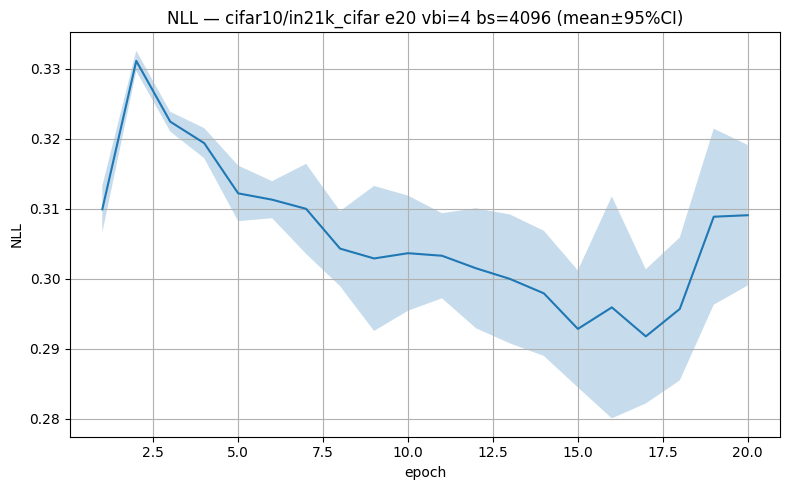

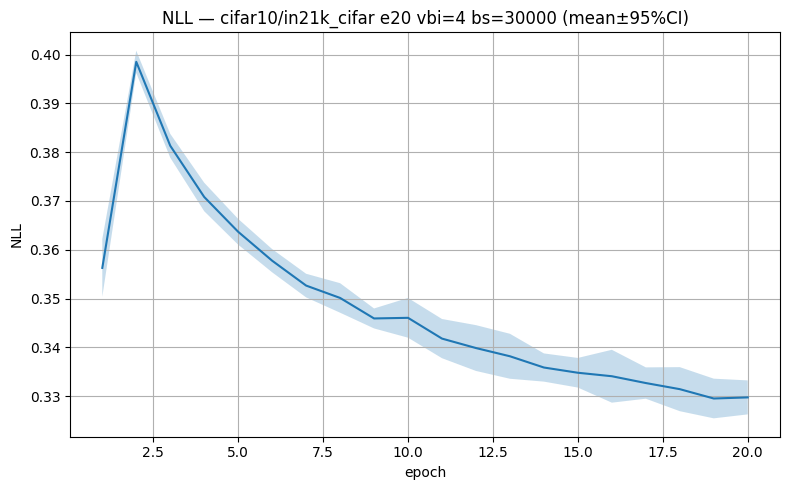

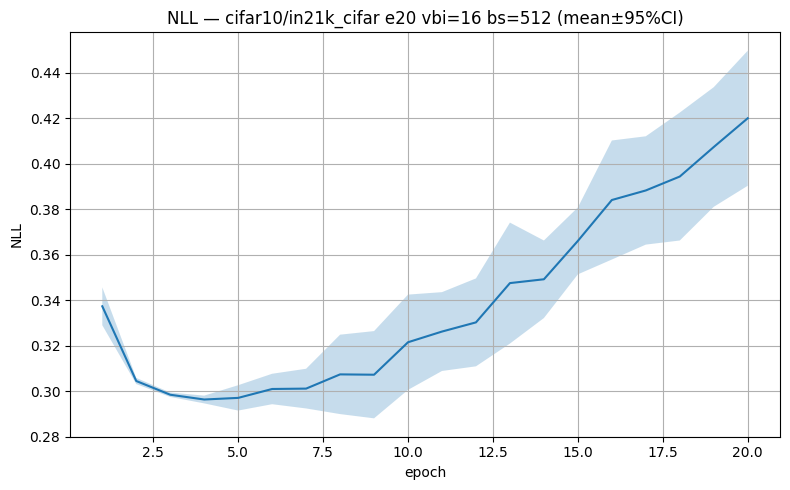

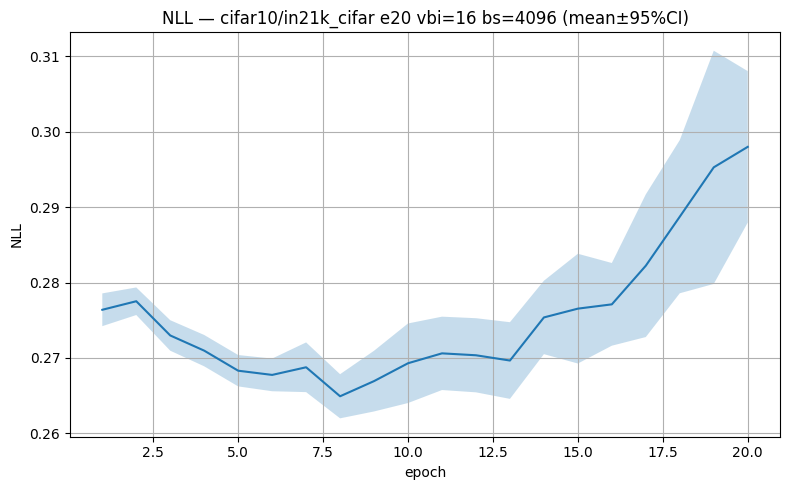

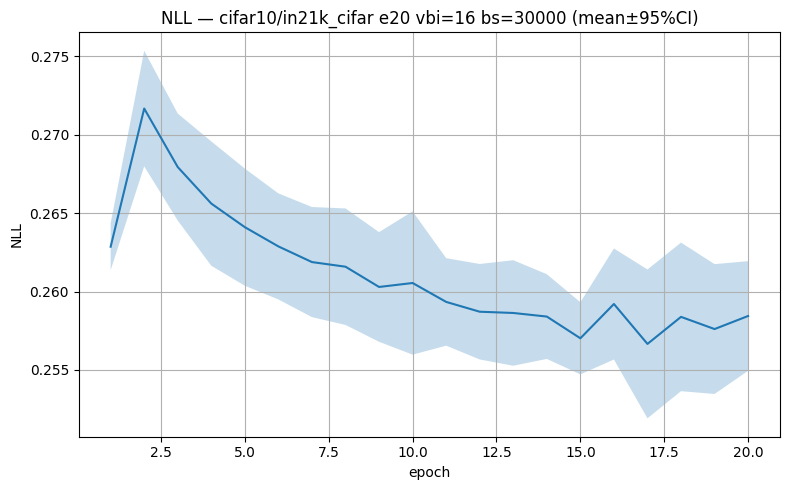

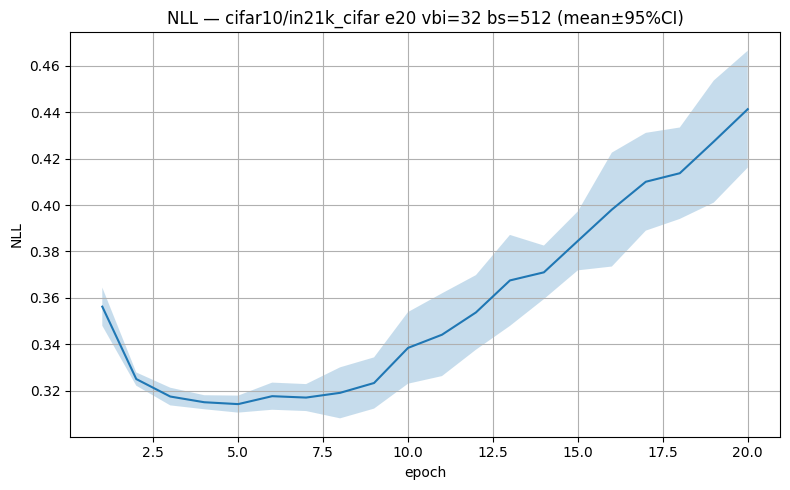

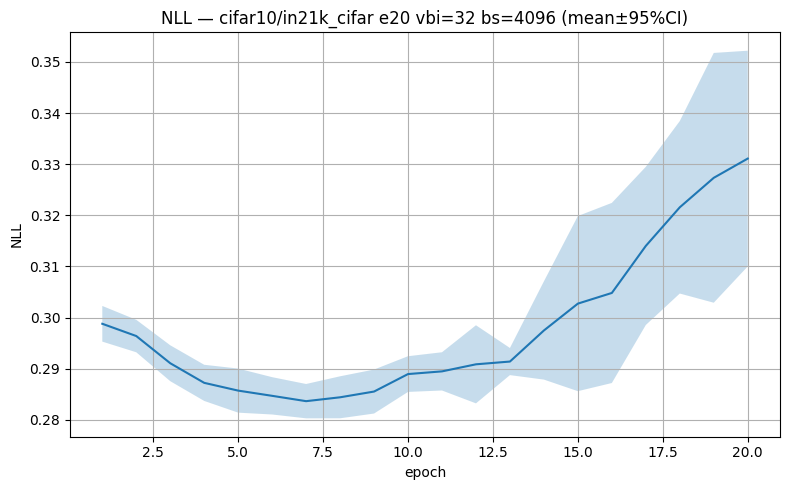

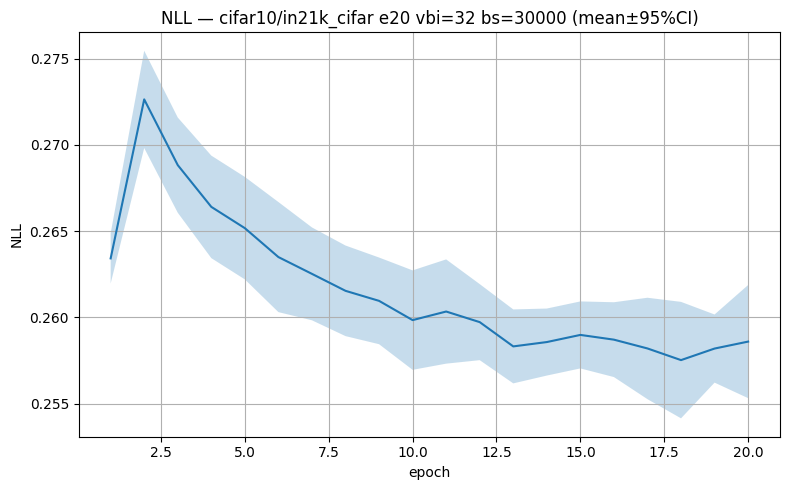

In [15]:
# %%
from concurrent.futures import ThreadPoolExecutor, as_completed

# Index runs by keys for quick lookup (using DF to get epochs)
KEYS = ["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]
runs_by_key = {}
for r in runs:
    cfg = dict(r.config or {})
    rid = r.id
    # epochs from DF (summary-backed)
    ep = DF.loc[DF["run_id"]==rid, "epochs"]
    ep = None if ep.empty else ep.iloc[0]
    key = (
        cfg.get("dataset"),
        cfg.get("pretrained"),
        cfg.get("batch_size"),
        cfg.get("num_vb_iters"),
        cfg.get("seed"),
        ep,
    )
    runs_by_key.setdefault(key, []).append(r)

def fetch_curve(run, metric: str):
    # Try decimated history; fallback to scan_history
    try:
        dfh = run.history(keys=["epoch", metric], samples=MAX_POINTS_PER_RUN)
        if dfh is None or dfh.empty or dfh[metric].dropna().empty:
            rows = list(run.scan_history(keys=["epoch", metric]))
            import pandas as pd
            dfh = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["epoch", metric])
    except Exception:
        rows = list(run.scan_history(keys=["epoch", metric]))
        import pandas as pd
        dfh = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["epoch", metric])
    dfh = dfh[["epoch", metric]].dropna()
    dfh["run_id"] = run.id
    return dfh

def aggregate_curves(dataset, pretrained, epochs, num_vb_iters, batch_size, metric):
    # collect runs for seeds 0..4 (keep last attempt if duplicates)
    curves = []
    for seed in [0,1,2,3,4]:
        key = (dataset, pretrained, batch_size, num_vb_iters, seed, epochs)
        candidates = runs_by_key.get(key, [])
        if not candidates:
            continue
        r = candidates[0] if len(candidates)==1 else sorted(candidates, key=lambda x: x.created_at)[-1]
        curves.append(fetch_curve(r, metric))
    if not curves:
        return pd.DataFrame(columns=["epoch","mean","lo","hi","n"])
    C = pd.concat(curves, ignore_index=True)
    C = C.groupby("epoch")[metric].agg(["mean","std","count"]).reset_index()
    C["sem"] = C["std"] / np.sqrt(np.clip(C["count"], 1, None))
    C["lo"]  = C["mean"] - 1.96*C["sem"]
    C["hi"]  = C["mean"] + 1.96*C["sem"]
    return C[["epoch","mean","lo","hi","count"]].rename(columns={"count":"n"})

def plot_curve(A, metric, title):
    if A.empty:
        print(f"[skip] no data for {title}")
        return
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(A["epoch"], A["mean"])
    ax.fill_between(A["epoch"], A["lo"], A["hi"], alpha=0.25)
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric.upper())
    fig.tight_layout()
    plt.show()

for metric in CURVE_METRICS:
    for vbi in CURVE_NUM_VB_ITERS:
        for bs in CURVE_BATCH_SIZES:
            A = aggregate_curves(CURVE_DATASET, CURVE_PRETRAINED, CURVE_EPOCHS, vbi, bs, metric)
            title = f"{metric.upper()} — {CURVE_DATASET}/{CURVE_PRETRAINED} e{CURVE_EPOCHS} vbi={vbi} bs={bs} (mean±95%CI)"
            plot_curve(A, metric, title)


### Curves for CIFAR-10 / in21k, epochs=20 (DA ON), batch_size=16384 — lines by num_vb_iters

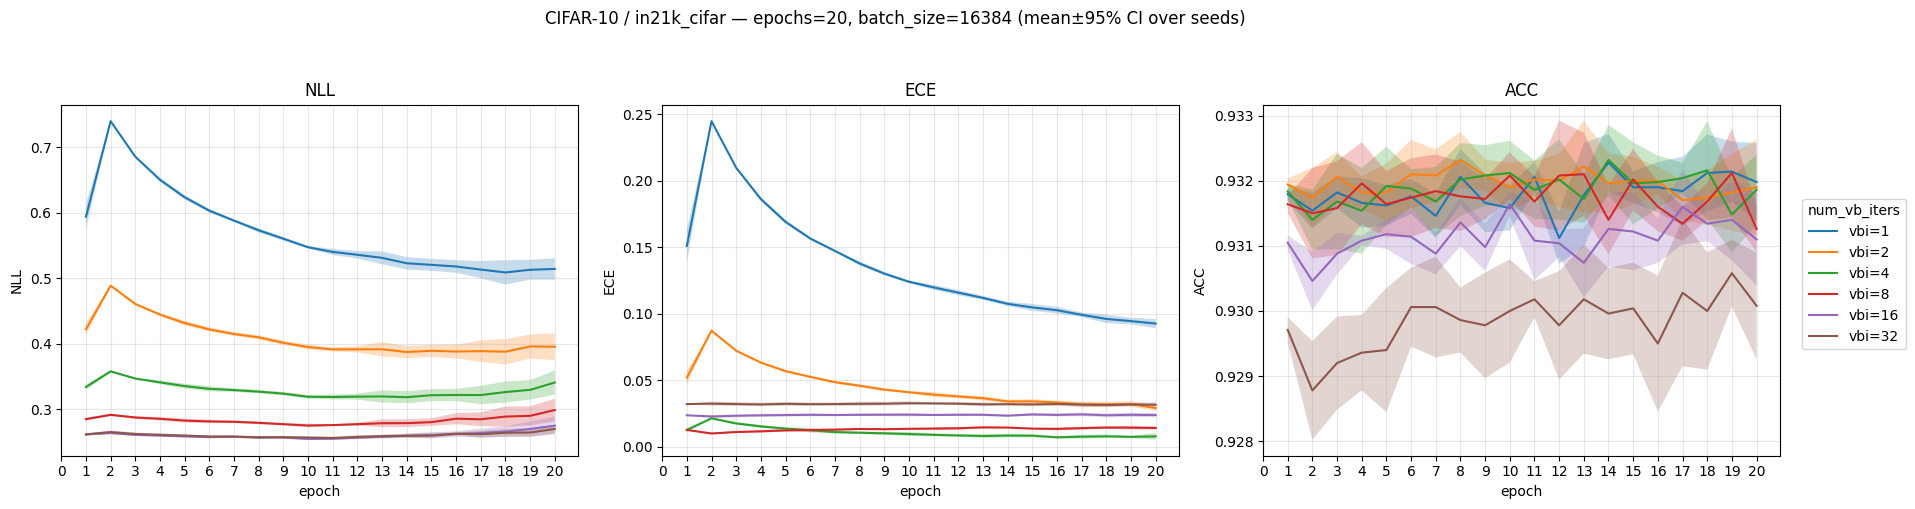

In [21]:


DATASET    = "cifar10"
PRETRAINED = "in21k_cifar"
EPOCHS     = 20
BATCH_SIZE = 16384
VB_LIST_ON = [1, 2, 4, 8, 16, 32]     # DA ON list
VB_LIST_OFF= [1, 2, 4, 8, 16, 32, 48, 64, 96, 128]  # DA OFF list
VB_LIST_TO_USE = VB_LIST_ON if EPOCHS==20 else VB_LIST_OFF
METRICS    = ["nll", "ece", "acc"]    # order in subplots (left to right)
MAX_POINTS_PER_RUN = 200

# ---- index runs by keys (reuse DF/runs you already fetched) ----
KEYS = ["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]
runs_by_key = {}
for r in runs:
    cfg = dict(r.config or {})
    rid = r.id
    ep = DF.loc[DF["run_id"]==rid, "epochs"]
    ep = None if ep.empty else ep.iloc[0]
    key = (
        cfg.get("dataset"),
        cfg.get("pretrained"),
        cfg.get("batch_size"),
        cfg.get("num_vb_iters"),
        cfg.get("seed"),
        ep,
    )
    runs_by_key.setdefault(key, []).append(r)

def fetch_curve(run, metric: str):
    # Try decimated history then fallback to scan_history
    try:
        dfh = run.history(keys=["epoch", metric], samples=MAX_POINTS_PER_RUN)
        if dfh is None or dfh.empty or dfh[metric].dropna().empty:
            rows = list(run.scan_history(keys=["epoch", metric]))
            dfh = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["epoch", metric])
    except Exception:
        rows = list(run.scan_history(keys=["epoch", metric]))
        dfh = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["epoch", metric])
    dfh = dfh[["epoch", metric]].dropna()
    dfh["run_id"] = run.id
    return dfh

def aggregate_curve_for_cell(vbi: int, metric: str) -> pd.DataFrame:
    # gather runs for seeds 0..4, keep the latest attempt if duplicates
    curves = []
    for seed in [0,1,2,3,4]:
        key = (DATASET, PRETRAINED, BATCH_SIZE, vbi, seed, EPOCHS)
        candidates = runs_by_key.get(key, [])
        if not candidates:
            continue
        r = candidates[0] if len(candidates)==1 else sorted(candidates, key=lambda x: x.created_at)[-1]
        curves.append(fetch_curve(r, metric))
    if not curves:
        return pd.DataFrame(columns=["epoch","mean","lo","hi","n"])
    C = pd.concat(curves, ignore_index=True)
    G = C.groupby("epoch")[metric].agg(["mean","std","count"]).reset_index()
    G["sem"] = G["std"] / np.sqrt(np.clip(G["count"], 1, None))
    G["lo"]  = G["mean"] - 1.96*G["sem"]
    G["hi"]  = G["mean"] + 1.96*G["sem"]
    return G.rename(columns={"count":"n"})

# ---- plot: 3 subplots, one per metric; a line per num_vb_iters ----
fig, axes = plt.subplots(1, 3, figsize=(18, 4.8), sharex=True)
for ax, metric in zip(axes, METRICS):
    legend_entries = []
    for vbi in VB_LIST_TO_USE:
        A = aggregate_curve_for_cell(vbi, metric)
        if A.empty:
            continue
        ax.plot(A["epoch"], A["mean"], label=f"vbi={vbi}")
        ax.fill_between(A["epoch"], A["lo"], A["hi"], alpha=0.25)
        legend_entries.append(f"vbi={vbi}")
    ax.set_title(metric.upper())
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric.upper())
    ax.grid(True, alpha=0.3)
    ax.set_xticks(np.arange(0, EPOCHS+1, 1))  # force integer x ticks from 0 to EPOCHS, step=2 for readability

# single legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5), title="num_vb_iters")

fig.suptitle(f"CIFAR-10 / {PRETRAINED} — epochs={EPOCHS}, batch_size={BATCH_SIZE} (mean±95% CI over seeds)", y=1.05)
fig.tight_layout()
plt.show()


### Export per epoch metrics (acc/ece/nll) for each run to CSV (for external analysis)

In [24]:

OUTDIR = "wandb_analysis_bllarse"
Path(OUTDIR).mkdir(parents=True, exist_ok=True)

# What to export
EXPORT_METRICS = ["acc", "ece", "nll"]
EXPORT_KEYS    = ["dataset","pretrained","batch_size","num_vb_iters","seed","epochs"]  # so downstream can group
KEEP_DUPLICATES = False   # False = keep latest attempt per config+seed; True = export all attempts
MAX_POINTS_PER_RUN = 200

# 1) decide which runs to export (finished, already in DF)
#    if duplicates exist for the same (keys + run attempt), keep the latest unless KEEP_DUPLICATES=True
if not KEEP_DUPLICATES:
    # keep only the latest attempt per exact (keys + seed)
    df_sorted = DF.sort_values(["dataset","pretrained","batch_size","num_vb_iters","seed","epochs","_runtime","run_id"])
    df_latest = df_sorted.drop_duplicates(subset=EXPORT_KEYS, keep="last").copy()
    runs_to_use = set(df_latest["run_id"].astype(str))
else:
    runs_to_use = set(DF["run_id"].astype(str))

print(f"Exporting {len(runs_to_use)} runs (KEEP_DUPLICATES={KEEP_DUPLICATES})")

# 2) build a mapping run_id -> (config columns) for fast join
cfg_cols = EXPORT_KEYS + ["run_id","name","group_id","state"]
CFG_MAP = DF.loc[DF["run_id"].isin(runs_to_use), cfg_cols].drop_duplicates(subset=["run_id"]).set_index("run_id")

# 3) fetch histories for each run_id and assemble per-epoch table
rows = []
missing_hist = 0

for rid in runs_to_use:
    run = next((r for r in runs if r.id == rid), None)
    if run is None:
        continue

    try:
        hist = run.history(keys=["epoch"] + EXPORT_METRICS, samples=MAX_POINTS_PER_RUN)
    except Exception:
        hist = None

    if hist is None or hist.empty:
        # rare fallback: try scan_history (slower)
        try:
            entries = list(run.scan_history(keys=["epoch"] + EXPORT_METRICS))
            hist = pd.DataFrame(entries) if entries else pd.DataFrame(columns=["epoch"] + EXPORT_METRICS)
        except Exception:
            hist = pd.DataFrame(columns=["epoch"] + EXPORT_METRICS)

    # clean + thin to rows with some metric present
    keep_cols = ["epoch"] + EXPORT_METRICS
    for k in keep_cols:
        if k not in hist.columns:
            hist[k] = np.nan
    hist = hist[keep_cols].copy()
    # drop rows where *all* metrics are NaN or epoch is NaN
    metric_mask = hist[EXPORT_METRICS].notna().any(axis=1)
    hist = hist[metric_mask & hist["epoch"].notna()]
    if hist.empty:
        missing_hist += 1
        continue

    # normalize epoch to int if it looks integral (optional)
    try:
        hist["epoch"] = pd.to_numeric(hist["epoch"], errors="coerce")
        # if epoch values are all near integers, round
        if hist["epoch"].dropna().sub(hist["epoch"].dropna().round()).abs().max() < 1e-6:
            hist["epoch"] = hist["epoch"].round().astype(int)
    except Exception:
        pass

    # attach config columns
    cfg = CFG_MAP.loc[rid]
    for c in EXPORT_KEYS + ["name","group_id","state"]:
        hist[c] = cfg[c]

    hist["run_id"] = rid
    rows.append(hist)

if not rows:
    raise RuntimeError("No histories to export — check filters or WANDB access.")

PER_EPOCH = pd.concat(rows, ignore_index=True)

# reorder columns: identifiers first, then metrics
cols_order = ["run_id","name","group_id","state"] + EXPORT_KEYS + ["epoch"] + EXPORT_METRICS
PER_EPOCH = PER_EPOCH[cols_order]

# save
full_path = Path(OUTDIR) / "per_epoch_metrics.csv.gz"
PER_EPOCH.to_csv(full_path, index=False, compression="gzip")
print("Saved:", full_path, "| rows:", len(PER_EPOCH), "cols:", len(PER_EPOCH.columns))

# also save a small sample for quick inspection
sample_path = Path(OUTDIR) / "per_epoch_metrics_sample.csv"
PER_EPOCH.head(5000).to_csv(sample_path, index=False)
print("Saved sample:", sample_path)

# quick peek
display(PER_EPOCH.head())
print("Unique runs exported:", PER_EPOCH["run_id"].nunique())
print("Unique (dataset,pretrained,bs,vbi,seed,epochs):", PER_EPOCH[EXPORT_KEYS].drop_duplicates().shape[0])
print("Runs with no usable history:", missing_hist)


Exporting 2384 runs (KEEP_DUPLICATES=False)


KeyboardInterrupt: 